# Technical Analysis

The goal of this project is to investigate popular technical indicator used to forecast trend of underlying ticker. Lets see if they work!

## Load Data

Select a wide variety of data to test whether indicator performance is based on type of underlying. Thus, the underlying we'll investigate on are:

- SSW.JO: Sibanye Stillwater (highly volatile South African stock in the Mining & Energy sector).

- PPE.JO: Purple Group (lowly volatile South African stock in Financial Services sector).

- SPY: The famous S&P500 ETF, representing broad U.S. equity market exposure.

- ^TYX: The US 30-Yr Treasury Yield, a key macroeconomic interest rate indicator.

- EZA: The iShares MSCI South Africa ETF, a proxy for South African equity market.

- USDZAR=X: The USD/ZAR exchange rate, representing currency risk and macroeconomic sentiment.

- BTC-USD: Bitcoin priced in USD, a highly volatile and non-traditional asset class.

- GC=F: Gold Futures price, a proxy for commodities movements.

NB: The underlying data is sourced from Yahoo Finance. While its not the most reliable or precise data provider, it is sufficient for exploratory analysis and prototyping.

In [1]:
#Import libraries & Yahoo Finance API
import datetime, time
import yfinance as yfin
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import itertools
from itertools import combinations

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
pd.set_option('future.no_silent_downcasting', True)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.display.float_format = "{:,.6f}".format #Set decimal places

In [2]:
# Starting and end dates
start = datetime.date(2020, 6, 1)
end = datetime.date(2025, 11, 26)

!pip install curl_cffi -U
from curl_cffi import requests
session = requests.Session(impersonate = 'chrome')

# Get SA stock data
df = yfin.download(["SSW.JO", "PPE.JO"], start, end, auto_adjust = False, session = session)["Adj Close"]

# Get US ETF & Treasury Yield data
df_etf = yfin.download(["SPY", "^TYX", "EZA"], start, end, auto_adjust = False, session = session)["Adj Close"]

# Get commodity future data 
df_gld = yfin.download(["GC=F"], start, end, auto_adjust = False, session = session)["Adj Close"]

# Get Weekend data
df_wkd = yfin.download(["USDZAR=X"], start, end, auto_adjust = False, session = session)["Adj Close"]
df_wkd1 = yfin.download(["BTC-USD"], start, end, auto_adjust = False, session = session)["Adj Close"]

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


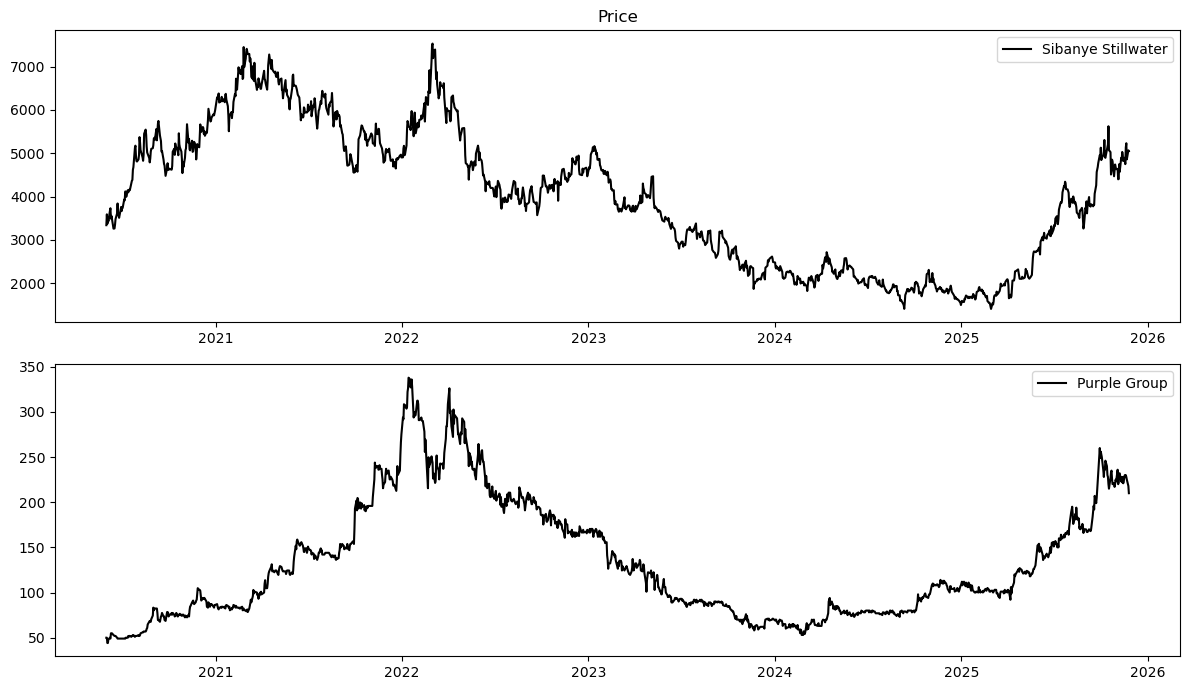

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7))

# Price Plot
axes[0].plot(df["SSW.JO"].index, df["SSW.JO"], label='Sibanye Stillwater', color='black')
axes[0].set_title('Price')
axes[0].legend()

axes[1].plot(df["PPE.JO"].index, df["PPE.JO"], label='Purple Group', color='black')
axes[1].legend()

plt.tight_layout()
plt.show()

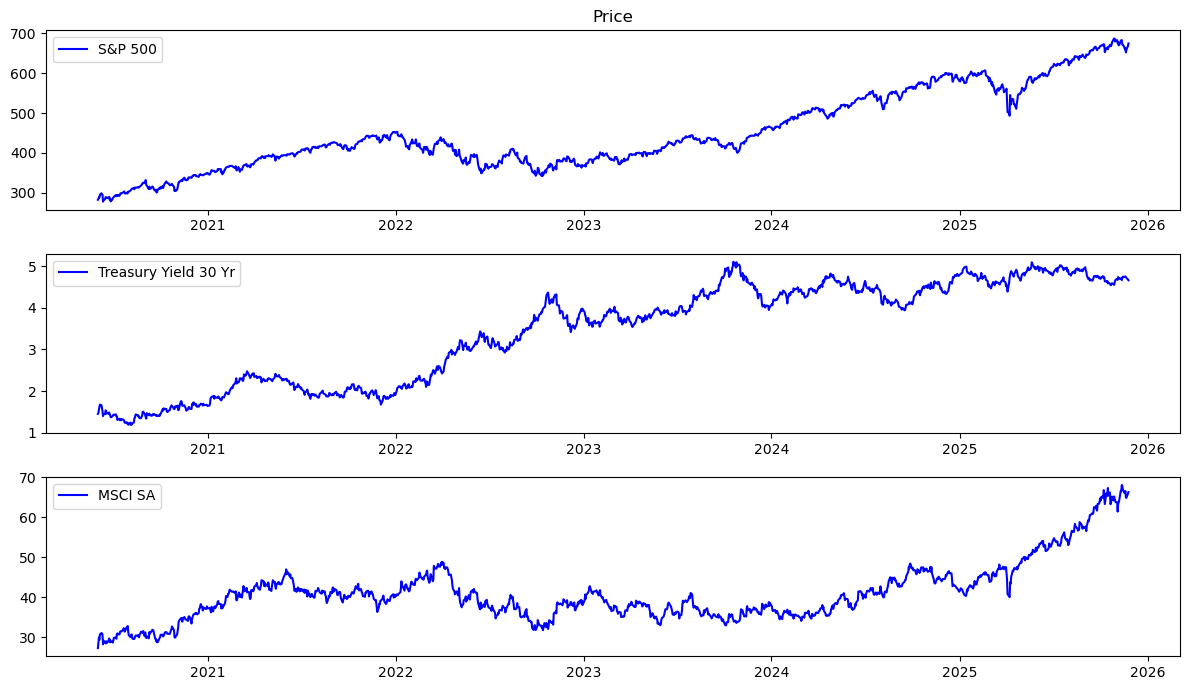

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7))

axes[0].plot(df_etf["SPY"].index, df_etf["SPY"], label='S&P 500', color='blue')
axes[0].set_title('Price')
axes[0].legend()

axes[1].plot(df_etf["^TYX"].index, df_etf["^TYX"], label='Treasury Yield 30 Yr', color='blue')
axes[1].legend()

axes[2].plot(df_etf["EZA"].index, df_etf["EZA"], label='MSCI SA', color='blue')
axes[2].legend()

plt.tight_layout()
plt.show()

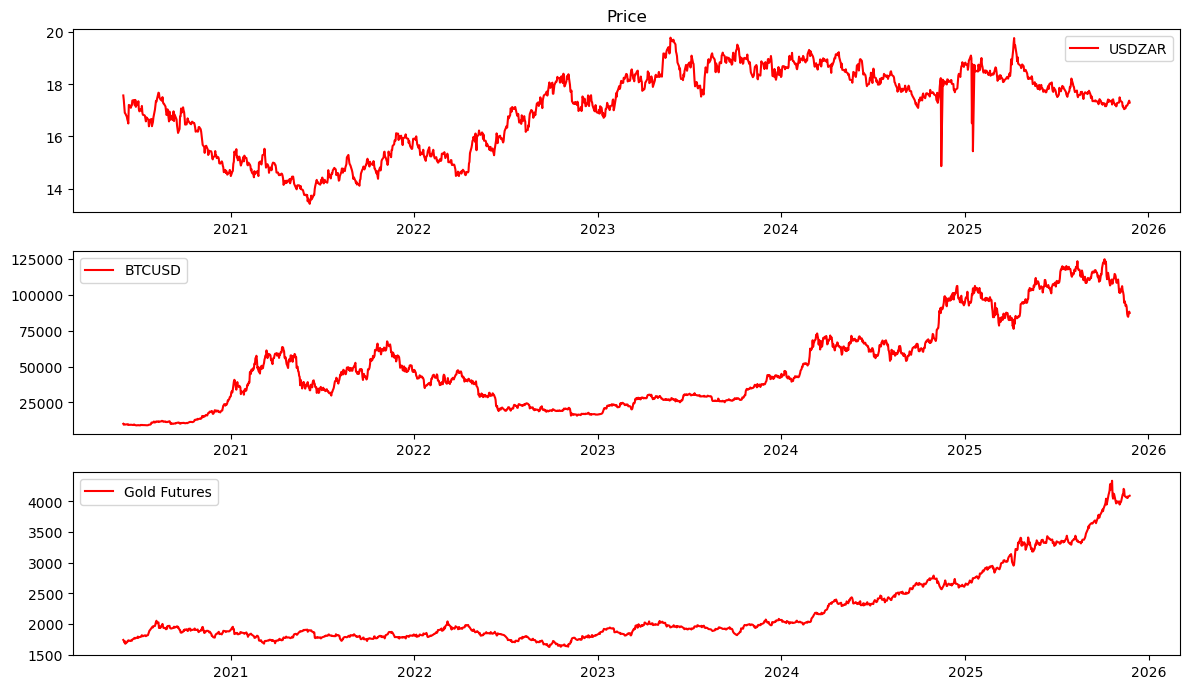

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7))

# Price Plot
axes[0].plot(df_wkd["USDZAR=X"].index, df_wkd["USDZAR=X"], label='USDZAR', color='red')
axes[0].set_title('Price')
axes[0].legend()

axes[1].plot(df_wkd1["BTC-USD"].index, df_wkd1["BTC-USD"], label='BTCUSD', color='red')
axes[1].legend()

axes[2].plot(df_gld["GC=F"].index, df_gld["GC=F"], label='Gold Futures', color='red')
axes[2].legend()

plt.tight_layout()
plt.show()

# Relative Strength Indicator

Definitely a supportive indicator, not used alone!

In [6]:
##RSI Calculation
def calculate_rsi(prices, period):
    delta = prices.diff() # Calculate price changes
    
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain_series = pd.Series(gain, index=prices.index)
    loss_series = pd.Series(loss, index=prices.index)

    #Smoothed averages (reacts better to changing market momentum)
    avg_gain = gain_series.ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = loss_series.ewm(alpha=1/period, min_periods=period).mean()

    rs = avg_gain / avg_loss # Relative Strength
    
    rsi = 100 - (100 / (1 + rs)) # RSI formula
    return rsi

In [7]:
def metr_rsi_v3(data, start_date, end_date, period, rsi_bnch, plot=True):
    # Datetime index and proper slicing
    data.index = pd.to_datetime(data.index)
    data = data.loc[start_date:end_date].sort_index()

    # Calculate RSI
    rsi = calculate_rsi(data, period)
    
    # Build working DataFrame
    data = pd.DataFrame({"Price": data, "RSI": rsi})

    # Base signals (threshold logic)
    data['Signal'] = np.select([data['RSI'] > rsi_bnch[0],
                                data['RSI'] < rsi_bnch[1]],['Sell', 'Buy'], default='Hold')

    # Trend filter
    data['Trend'] = np.where(data['Price'].diff() < 0, 'Downtrend', 'Uptrend')
    
    #Position
    data['Position'] = data['Signal'].replace('Hold', pd.NA).ffill()
    data['Position'] = data['Position'].replace(pd.NA, 'Hold')

    # Implement Short-Selling
    data['Return (%)'] = np.where(data['Position'] == 'Buy', data['Price'].pct_change(), #Profit = (next - current)/current
                             np.where(data['Position'] == 'Sell', -data['Price'].pct_change(), 0)) # Short profit = (current - next)/next

    # False Signals
    data['False_Signal'] = np.where((data['Position'] == 'Buy') & (data['Price'].pct_change()<0), 1,
                                    np.where((data['Position'] == 'Sell') & (data['Price'].pct_change()>0), 1, 0))
    
    # Results
    results = []
    for i in range(len(data)): 
        results.append({
            'Date': data.index[i],
            'Price': data['Price'].iloc[i],
            'Trend': data['Trend'].iloc[i],
            'RSI': data['RSI'].iloc[i],
            'Position': data['Position'].iloc[i],
            'Return (%)': data['Return (%)'].iloc[i],
            'False_Signal': data['False_Signal'].iloc[i] })
    results_df = pd.DataFrame(results).set_index('Date')

    # Additional Metrics 
    strategy_pct_gain = (results_df['Return (%)'].add(1).prod())-1
    if (results_df['False_Signal']==1).sum()>0:
        win_loss_rat = (results_df['False_Signal']==0).sum() / (results_df['False_Signal']==1).sum()
    else:
        win_loss_rat = 2
    
    # Performance Summary
    summary = results_df.groupby(['Position', 'Trend'])['Return (%)'].agg(['count', 'mean', 'median'])
    
    # Visualization 
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        # Price Plot
        axes[0].plot(data.index, data['Price'], label='Price', color='black')

        buy_points = data[data['Signal'] == 'Buy'].index
        sell_points = data[data['Signal'] == 'Sell'].index

        axes[0].scatter(buy_points, data.loc[buy_points, 'Price'], color='green', marker='^', label='Buy Signal')
        axes[0].scatter(sell_points, data.loc[sell_points, 'Price'], color='red', marker='v', label='Sell Signal')

        fs_points = data[data['False_Signal'] == 1].index
        axes[0].scatter(fs_points, data.loc[fs_points, 'Price'], color='orange', marker='x', label='False Signal')
        
        axes[0].set_title('Price and Signals')
        axes[0].legend()

        # RSI Plot
        axes[1].plot(data.index, data['RSI'], label='RSI', color='blue')
        axes[1].axhline(rsi_bnch[0], color='red', linestyle='--', label=f'Overbought {rsi_bnch[0]}')
        axes[1].axhline(rsi_bnch[1], color='green', linestyle='--', label=f'Oversold {rsi_bnch[1]}')
        axes[1].set_title('RSI Levels')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    return {'Dataframe': results_df, 
            'Summary': summary, 
            'Total Return (%)': np.round(strategy_pct_gain*100, 4),
            'Win/Loss Ratio': np.round(win_loss_rat, 4)}

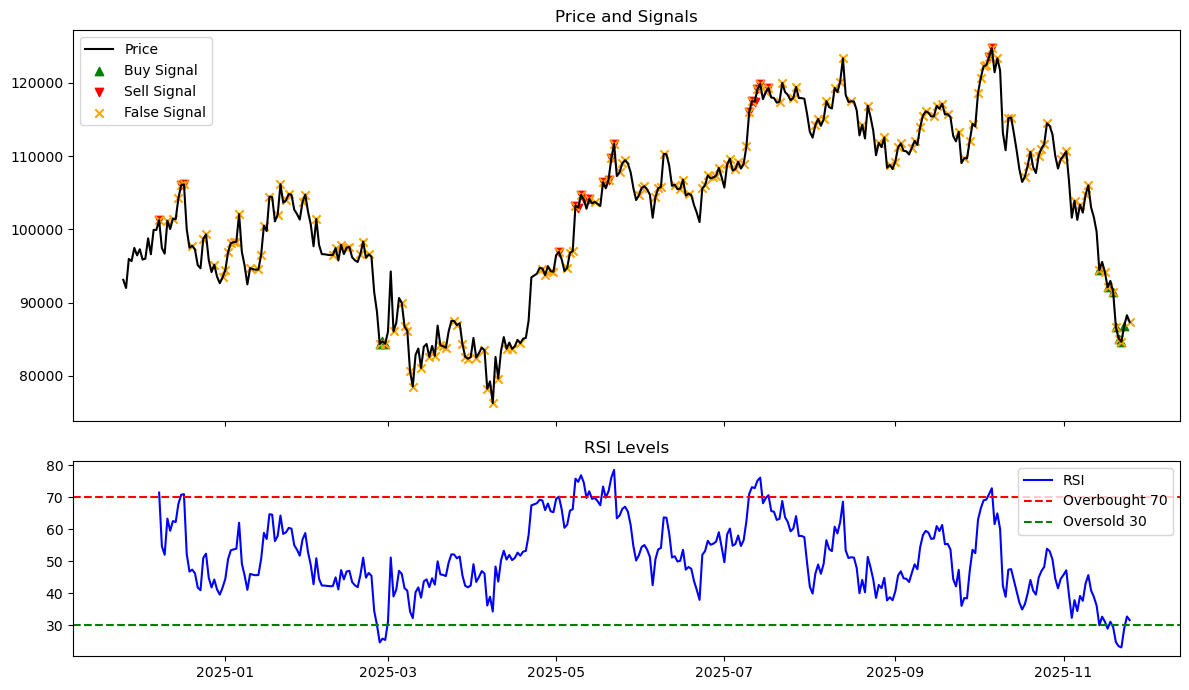

                   Price      Trend       RSI Position  Return (%)  \
Date                                                                 
2024-11-25 93,102.296875    Uptrend       NaN     Hold    0.000000   
2024-11-26 91,985.320312  Downtrend       NaN     Hold    0.000000   
2024-11-27 95,962.531250    Uptrend       NaN     Hold    0.000000   
2024-11-28 95,652.468750  Downtrend       NaN     Hold    0.000000   
2024-11-29 97,461.523438    Uptrend       NaN     Hold    0.000000   
...                  ...        ...       ...      ...         ...   
2025-11-21 85,090.687500  Downtrend 23.455865      Buy   -0.017790   
2025-11-22 84,648.359375  Downtrend 23.086270      Buy   -0.005198   
2025-11-23 86,805.007812    Uptrend 28.963539      Buy    0.025478   
2025-11-24 88,270.562500    Uptrend 32.725624      Buy    0.016883   
2025-11-25 87,341.890625  Downtrend 31.584162      Buy   -0.010521   

            False_Signal  
Date                      
2024-11-25             0  
2024-11-

In [8]:
#Function inputs:
    #Data - stock (adjusted) closing price
    #Start Date - The first date of analysis
    #End Date - The last date of analysis
    #NB: Analysis options include either duration measure (i.e. 1-,3-,6-month periods) or independently adjust start & end dates
    #Period - The duration of RSI measurement
    #Lookahead - Holding period, i.e. how many days you hold a stock before a 'new' position is taken
    #MA_lwr - Lower MA window in trend filter
    #MA_upp - Upper MA window in trend filter
    #rsi_upp - Upper bound for RSI 
    #rsi_lwr - Lower bound for RSI 

#Function outputs:
    #Summary - Computes metrics of bps change grouped by Signal & Trend
    #Results - Dataframe with results for each trading day position
    #Data - Output of RSI and Trend Filter trading strategy from price data

#An example: 
f_rez= metr_rsi_v3(data=df_wkd1["BTC-USD"] , start_date=df.index[-1] - pd.DateOffset(years=1), end_date=df.index[-1], period=14, 
                     rsi_bnch=(70,30), plot=True)
print(f_rez['Dataframe'])
print(f_rez['Summary'])
print(f_rez['Total Return (%)'])
print(f_rez['Win/Loss Ratio'])

In [9]:
# Start timer
start_time = time.time()

# Define dats
dats = [df["SSW.JO"], df["PPE.JO"], df_etf["SPY"], df_etf["^TYX"], df_etf["EZA"], df_wkd["USDZAR=X"], df_wkd1["BTC-USD"], df_gld["GC=F"]]

# Define date ranges
starts = [
    df.index[-1] - pd.DateOffset(years=5, months=5, days=4),
    df.index[-1] - pd.DateOffset(years=5, months=0),
    df.index[-1] - pd.DateOffset(years=1, months=0),
    df.index[-1] - pd.DateOffset(years=0, months=10, days=4), #YTD
    df.index[-1] - pd.DateOffset(years=0, months=6),
    df.index[-1] - pd.DateOffset(years=0, months=3),
    df.index[-1] - pd.DateOffset(years=0, months=1),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=14),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=7)
]

ends = [
    df.index[-1]
]

# Other hyperparameters
periods = [4, 7, 14]
rsi_bnchs = [(70, 30), (80, 20), (60, 40)]

# Define parameter grid
param_grid = list(itertools.product(
    dats, starts, ends, periods, rsi_bnchs
))

results = []
best_score = float('-inf')
less_score = float('inf')
best_params = None
less_params = None

best_rat = float('-inf')
less_rat = float('inf')
best_params_rat = None
less_params_rat = None

def evaluate_params(params):
    dat, start, end, period, rsi_bnch = params

    if end <= start:
        return None

    try:
        f_summ = metr_rsi_v3(data=dat, start_date=start, end_date=end, period=period, rsi_bnch=rsi_bnch, plot=False) 
        
        return {
            'Data': dat.name,
            'Start': start,
            'End': end,
            'Period': period,
            'RSI_Benchmark': rsi_bnch,
            'Win/Loss_Ratio': f_summ['Win/Loss Ratio'],
            'Total Return (%)': f_summ['Total Return (%)']
        }

    except Exception as e:
        print(f"Error for {dat.name}, {start}, {end}, {period}, {rsi_bnch}: {e}")
        return None

# Run grid search with progress bar and parallel execution
with ThreadPoolExecutor() as executor:
    for result in tqdm(executor.map(evaluate_params, param_grid), total=len(param_grid)):
        if result:
            #Performance Measure
            results.append(result)
            score = result['Total Return (%)']
            rat = result['Win/Loss_Ratio']
            if score > best_score:
                best_score = score
                best_params = result
            elif score < less_score:
                less_score = score
                less_params = result
                
            if rat > best_rat:
                best_rat = rat
                best_params_rat = result
            elif rat < less_rat:
                less_rat = rat
                less_params_rat = result

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Output best and worst results
if best_params:
    print("\nBest combination on price found:")
    print(best_params)
    print(f"Avg Price Gained: {best_score:.2f}")

if less_params:
    print("\nWorst combination on price found:")
    print(less_params)
    print(f"Avg Price Lost: {less_score:.2f}")

if best_params_rat:
    print("\nBest combination on ratio found:")
    print(best_params_rat)
    print(f"Best Win/Loss ratio: {best_rat:.4f}")

if less_params_rat:
    print("\nWorst combination on ratio found:")
    print(less_params_rat)
    print(f"Worst Win/Loss ratio: {less_rat:.4f}")

# Total runtime
end_time = time.time()
print(f"\nTotal Run Time: {(end_time - start_time)/60:.2f} minutes")

100%|██████████| 648/648 [00:34<00:00, 18.77it/s]


Best combination on price found:
{'Data': 'BTC-USD', 'Start': Timestamp('2025-08-25 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'Period': 7, 'RSI_Benchmark': (80, 20), 'Win/Loss_Ratio': 2.4444, 'Total Return (%)': 22.9273}
Avg Price Gained: 22.93

Worst combination on price found:
{'Data': 'SSW.JO', 'Start': Timestamp('2020-06-21 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'Period': 4, 'RSI_Benchmark': (60, 40), 'Win/Loss_Ratio': 0.6095, 'Total Return (%)': -100.0}
Avg Price Lost: -100.00

Best combination on ratio found:
{'Data': 'SSW.JO', 'Start': Timestamp('2020-11-25 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'Period': 14, 'RSI_Benchmark': (80, 20), 'Win/Loss_Ratio': 28.0698, 'Total Return (%)': -30.6136}
Best Win/Loss ratio: 28.0698

Worst combination on ratio found:
{'Data': '^TYX', 'Start': Timestamp('2025-08-25 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'Period': 4, 'RSI_Benchmark': (60, 40), 'Win/Loss_Ratio': 0.5349, 'Total Return (%)': -

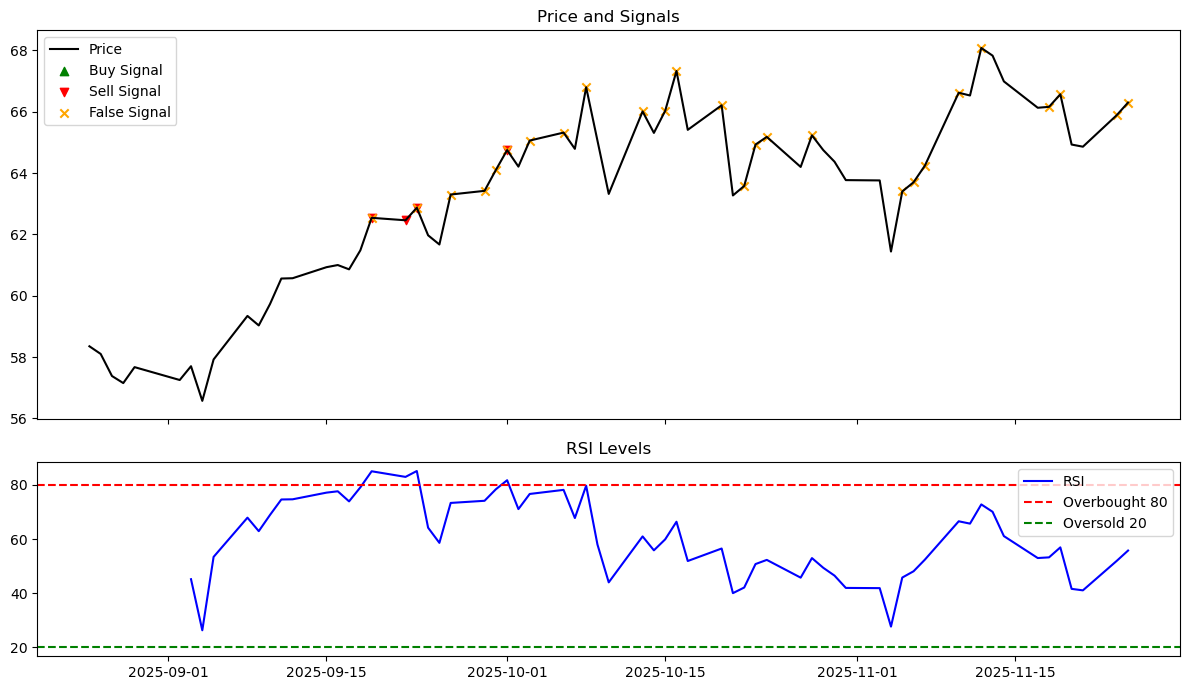

{'Dataframe':                Price      Trend       RSI Position  Return (%)  False_Signal
 Date                                                                        
 2025-08-25 58.349998    Uptrend       NaN     Hold    0.000000             0
 2025-08-26 58.099998  Downtrend       NaN     Hold    0.000000             0
 2025-08-27 57.380001  Downtrend       NaN     Hold    0.000000             0
 2025-08-28 57.150002  Downtrend       NaN     Hold    0.000000             0
 2025-08-29 57.669998    Uptrend       NaN     Hold    0.000000             0
 ...              ...        ...       ...      ...         ...           ...
 2025-11-19 66.570000    Uptrend 56.938912     Sell   -0.006197             1
 2025-11-20 64.930000  Downtrend 41.627012     Sell    0.024636             0
 2025-11-21 64.860001  Downtrend 41.076943     Sell    0.001078             0
 2025-11-24 65.889999    Uptrend 51.971885     Sell   -0.015880             1
 2025-11-25 66.300003    Uptrend 55.769890     Sell

In [10]:
##Best combination
metr_rsi_v3(data=df_etf["EZA"], start_date=best_params['Start'], end_date=best_params['End'], period=best_params['Period'], 
            rsi_bnch=best_params['RSI_Benchmark'], plot=True)

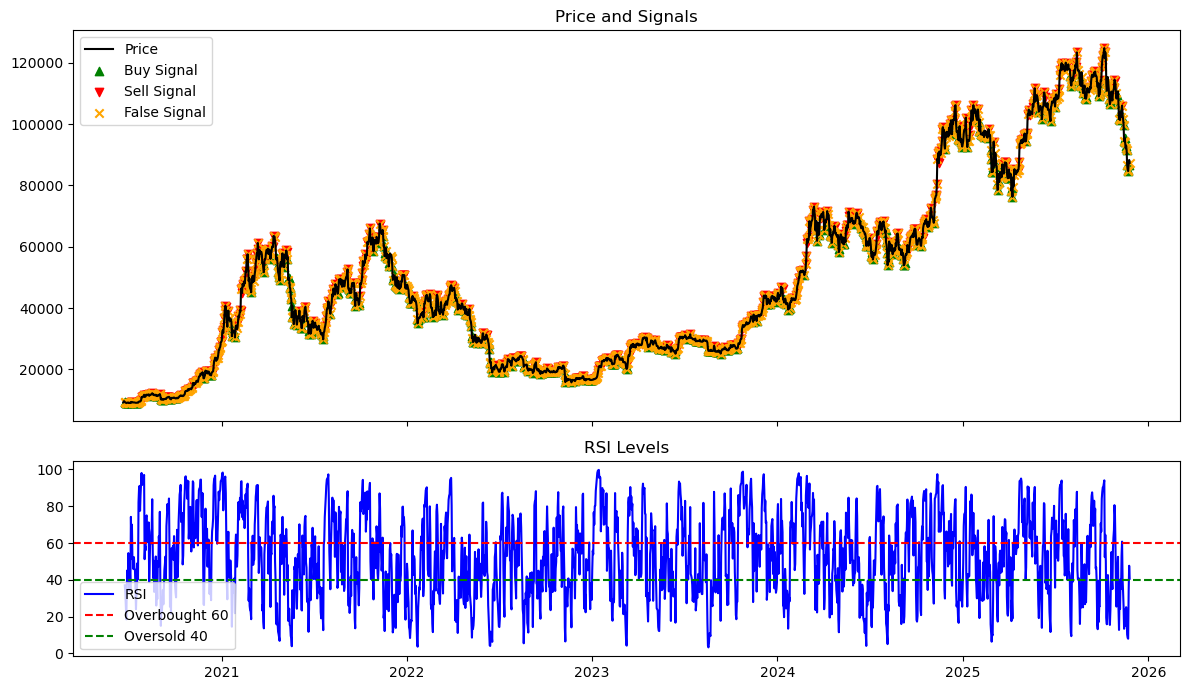

{'Dataframe':                    Price      Trend       RSI Position  Return (%)  \
 Date                                                                 
 2020-06-21  9,303.629883    Uptrend       NaN     Hold    0.000000   
 2020-06-22  9,648.717773    Uptrend       NaN     Hold    0.000000   
 2020-06-23  9,629.658203  Downtrend       NaN     Hold    0.000000   
 2020-06-24  9,313.610352  Downtrend 37.012162      Buy   -0.032820   
 2020-06-25  9,264.813477  Downtrend 32.927286      Buy   -0.005239   
 ...                  ...        ...       ...      ...         ...   
 2025-11-21 85,090.687500  Downtrend  8.468386      Buy   -0.017790   
 2025-11-22 84,648.359375  Downtrend  7.950596      Buy   -0.005198   
 2025-11-23 86,805.007812    Uptrend 34.132335      Buy    0.025478   
 2025-11-24 88,270.562500    Uptrend 47.629082      Buy    0.016883   
 2025-11-25 87,341.890625  Downtrend 40.600231      Buy   -0.010521   
 
             False_Signal  
 Date                      
 2020-

In [11]:
##Worst combination  
metr_rsi_v3(data=df_wkd1["BTC-USD"], start_date=less_params['Start'], end_date=less_params['End'], period=less_params['Period'], 
            rsi_bnch=less_params['RSI_Benchmark'], plot=True)

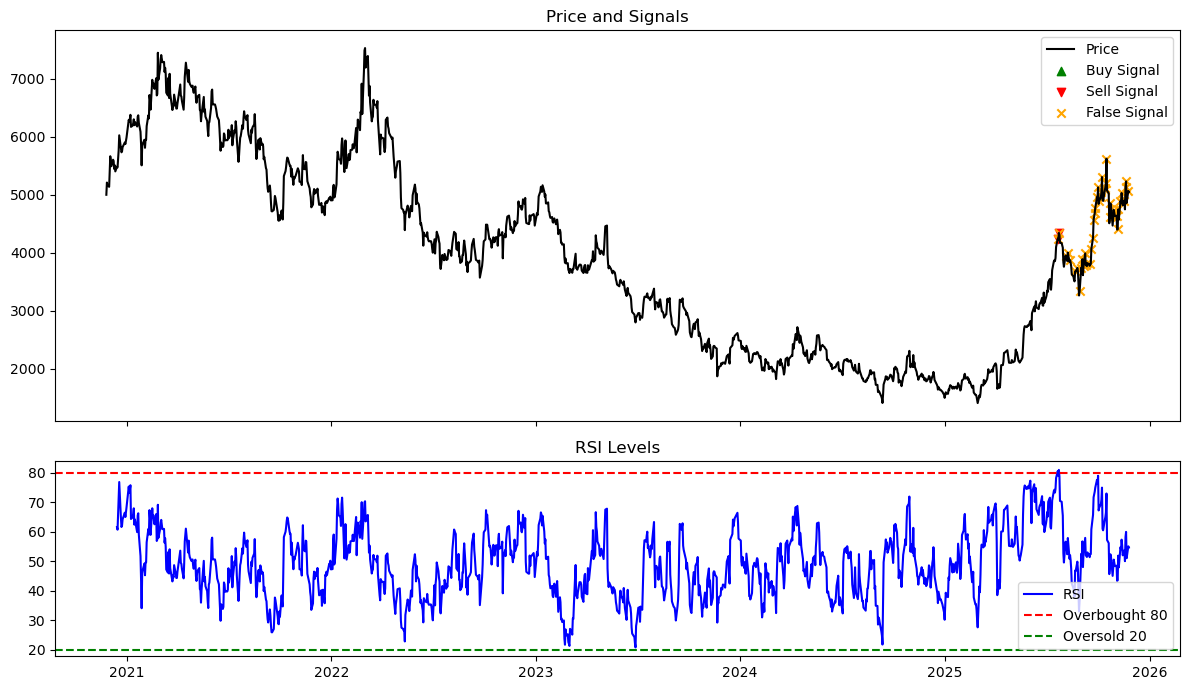

{'Dataframe':                   Price      Trend       RSI Position  Return (%)  \
 Date                                                                
 2020-11-25 5,001.276855    Uptrend       NaN     Hold    0.000000   
 2020-11-26 5,211.826172    Uptrend       NaN     Hold    0.000000   
 2020-11-27 5,160.935547  Downtrend       NaN     Hold    0.000000   
 2020-11-30 5,138.982422  Downtrend       NaN     Hold    0.000000   
 2020-12-01 5,383.458008    Uptrend       NaN     Hold    0.000000   
 ...                 ...        ...       ...      ...         ...   
 2025-11-19 5,138.000000    Uptrend 58.186634     Sell   -0.081684   
 2025-11-20 5,232.000000    Uptrend 59.900835     Sell   -0.018295   
 2025-11-21 4,860.000000  Downtrend 50.991522     Sell    0.071101   
 2025-11-24 5,068.000000    Uptrend 55.019956     Sell   -0.042798   
 2025-11-25 5,050.000000  Downtrend 54.601679     Sell    0.003552   
 
             False_Signal  
 Date                      
 2020-11-25        

In [12]:
##Best combination (on Win/Loss ratio)
metr_rsi_v3(data=df["SSW.JO"], start_date=best_params_rat['Start'], end_date=best_params_rat['End'], period=best_params_rat['Period'], 
            rsi_bnch=best_params_rat['RSI_Benchmark'], plot=True)

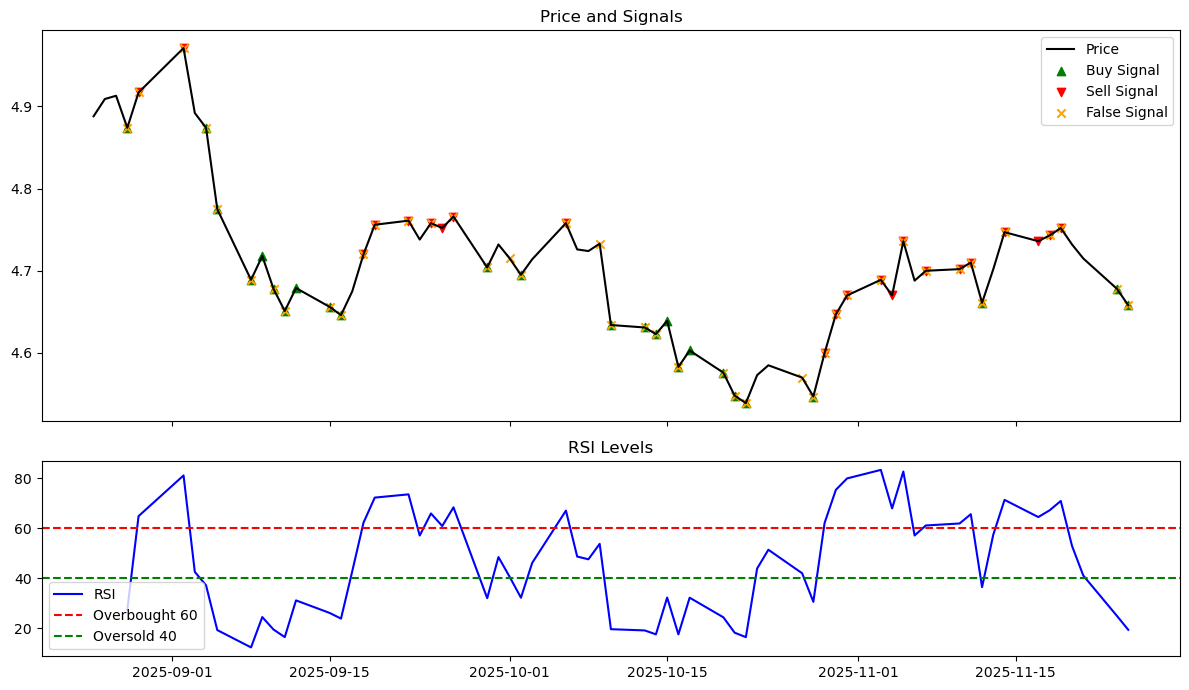

{'Dataframe':               Price      Trend       RSI Position  Return (%)  False_Signal
 Date                                                                       
 2025-08-25 4.888000    Uptrend       NaN     Hold    0.000000             0
 2025-08-26 4.909000    Uptrend       NaN     Hold    0.000000             0
 2025-08-27 4.913000    Uptrend       NaN     Hold    0.000000             0
 2025-08-28 4.874000  Downtrend 27.526234      Buy   -0.007938             1
 2025-08-29 4.917000    Uptrend 64.910866     Sell   -0.008822             1
 ...             ...        ...       ...      ...         ...           ...
 2025-11-19 4.752000    Uptrend 70.971754     Sell   -0.001897             1
 2025-11-20 4.732000  Downtrend 52.989481     Sell    0.004209             0
 2025-11-21 4.715000  Downtrend 41.168045     Sell    0.003593             0
 2025-11-24 4.678000  Downtrend 24.989512      Buy   -0.007847             1
 2025-11-25 4.658000  Downtrend 19.473875      Buy   -0.004275 

In [13]:
##Worst combination (on Win/Loss ratio)
metr_rsi_v3(data=df_etf["^TYX"], start_date=less_params_rat['Start'], end_date=less_params_rat['End'], period=less_params_rat['Period'], 
            rsi_bnch=less_params_rat['RSI_Benchmark'], plot=True)

In [14]:
#Analysis
results_rsi = results_df

# Print top results
print(results_rsi.sort_values(by='Total Return (%)', ascending=False).dropna())

# Descriptive statistics
print("Descriptive Statistics for Total Return (%):")
print(results_rsi['Total Return (%)'].describe())

# Group-wise average scores by Data
group_summary = results_rsi.groupby(['Data'])['Total Return (%)'].mean().reset_index()

print("\n Parameter Combinations by Data:")
print(group_summary.sort_values(by='Total Return (%)', ascending=False))

# By Period
group_summary = results_rsi.groupby(['Period'])['Total Return (%)'].mean().reset_index()

print("\nTop Parameter Combinations by Period:")
print(group_summary.sort_values(by='Total Return (%)', ascending=False))

# By RSI Benchmark
group_summary = results_rsi.groupby(['RSI_Benchmark'])['Total Return (%)'].mean().reset_index()

print("\nTop Parameter Combinations by RSI Benchmark:")
print(group_summary.sort_values(by='Total Return (%)', ascending=False))

         Data      Start        End  Period RSI_Benchmark  Win/Loss_Ratio  \
535   BTC-USD 2025-08-25 2025-11-25       7      (80, 20)        2.444400   
526   BTC-USD 2025-05-25 2025-11-25       7      (80, 20)        1.176500   
429  USDZAR=X 2024-11-25 2025-11-25      14      (70, 30)        1.158300   
249      ^TYX 2020-06-21 2025-11-25      14      (70, 30)        1.051100   
271      ^TYX 2025-01-21 2025-11-25       4      (80, 20)        1.337000   
..        ...        ...        ...     ...           ...             ...   
83     PPE.JO 2020-06-21 2025-11-25       4      (60, 40)        0.976700   
11     SSW.JO 2020-11-25 2025-11-25       4      (60, 40)        0.608800   
497   BTC-USD 2020-11-25 2025-11-25       4      (60, 40)        0.701100   
488   BTC-USD 2020-06-21 2025-11-25       4      (60, 40)        0.694300   
2      SSW.JO 2020-06-21 2025-11-25       4      (60, 40)        0.609500   

     Total Return (%)  
535         22.927300  
526         18.827700  
429

## Conclusion

From the above analysis, we observe that RSI works best on Sibanye Stillwater, within the period of 17 Oct 2024 to 17 July 2025. It had parameters: 

- Lookahead = 20: The underlying trading positions (i.e. buy, hold or sell) were changed after 20 business days, if need be.
- MA_lwr = 30: In determining underlying trend filter, the shorter window is 30 days
- MA_upp = 50: Upper window is 50 days.
- Period = 14: In calculation of underlying RSI metric, the most previous 14 closing prices were used to compute momentum.
- RSI_Benchmark = (80, 20): The RSI thresholds used where 80-20% for overbought and oversold regions.
- Score = 1117.62: This is the total basis point trade profit gained from following strategy.

The RSI seemed to not have effectively generated profit for the trader as the visual indicates that the trade gains were not due to RSI triggers.

Whilst the worst performing trading strategy indicated that RSI constantly indicated to take a bear position during an upward trending in Sibanye Stillwater share price.

# MA Cross

Problem with cummulative return calculations

In [15]:
def moving_average_crossover(prices, short_window=50, long_window=200):
    if short_window <= 0 or long_window <= 0:
        raise ValueError("Moving average windows must be positive integers.")
    if short_window >= long_window:
        raise ValueError("short_window must be less than long_window.")

    # Calculate moving averages
    prices["Short_MA"] = prices["Price"].rolling(window=short_window, min_periods=1).mean()
    prices["Long_MA"] = prices["Price"].rolling(window=long_window, min_periods=1).mean()

    # Generate signals: 1 = Buy (Golden Cross), -1 = Sell (Death Cross), 0 = Hold
    prices["Signal"] = 'Hold'
    prices.loc[prices["Short_MA"] > prices["Long_MA"], "Signal"] = 'Buy'
    prices.loc[prices["Short_MA"] < prices["Long_MA"], "Signal"] = 'Sell'
    
    # Detect crossover points (change in signal)
    prices["Crossover"] = (prices["Signal"] != prices["Signal"].shift(1))
    prices.iloc[0, prices.columns.get_loc("Crossover")] = False

    return prices

In [16]:
def metr_ma_crx_v2(data, start_date, end_date, ma_upp, ma_lwr, plot=True):
    #Slice Data
    data = data.loc[start_date:end_date].sort_index()
    
    data.rename(columns={data.columns[0]: "Price"}, inplace=True)
    
    #Apply technical
    ma_X = moving_average_crossover(prices=data, short_window=ma_lwr, long_window=ma_upp)

    #Actual Daily Price Trend
    ma_X['Trend'] = np.where(ma_X['Price'].diff()<0, 'Downtrend', 'Uptrend')
    
    # Implement Short-Selling
    ma_X['Return (%)'] = np.where(ma_X['Signal'] == 'Buy', ma_X['Price'].pct_change(), 
                             np.where(ma_X['Signal'] == 'Sell', -ma_X['Price'].pct_change(), 0)) 

    # False Signals
    ma_X['False_Signal'] = np.where((ma_X['Signal'] == 'Buy') & (ma_X['Price'].pct_change()<0), 1,
                                    np.where((ma_X['Signal'] == 'Sell') & (ma_X['Price'].pct_change()>0), 1, 0))
    
    # Results
    results = []
    for i in range(len(ma_X)): 
        results.append({
            'Date': ma_X.index[i],
            'Price': ma_X['Price'].iloc[i],
            'Trend': ma_X['Trend'].iloc[i],
            'Short_MA': ma_X['Short_MA'].iloc[i],
            'Long_MA': ma_X['Long_MA'].iloc[i],
            'MA Signal': ma_X['Signal'].iloc[i],
            'Return (%)': ma_X['Return (%)'].iloc[i],
            'False_Signal': ma_X['False_Signal'].iloc[i] })
    results_df = pd.DataFrame(results).set_index('Date')
    
    # Additional Metrics
    strategy_pct_gain = np.sum(results_df['Return (%)']) #(results_df['Return (%)'].add(1).prod())-1
    
    if (results_df['False_Signal']==1).sum()>0:
        win_loss_rat = (results_df['False_Signal']==0).sum() / (results_df['False_Signal']==1).sum()
    else:
        win_loss_rat = 2
    
    # Performance Summary
    summary = results_df.groupby(['MA Signal', 'Trend'])['Return (%)'].agg(['count', 'mean', 'median'])
    
    # Visualization 
    if plot:
        fig, axes = plt.subplots(1, 1, figsize=(12, 4), sharex=True)

        # Price Plot
        axes.plot(ma_X.index, ma_X['Price'], label='Price', color='black')
        axes.plot(ma_X['Short_MA'], label=f'Short MA - {ma_lwr}', linestyle='--', alpha=0.6)
        axes.plot(ma_X['Long_MA'], label=f'Long MA - {ma_upp}', linestyle='--', alpha=0.6)

        gcrss_pnt = ma_X[(ma_X['Crossover'] == True) & (ma_X['Signal'] == 'Buy')].index
        dcrss_pnt = ma_X[(ma_X['Crossover'] == True) & (ma_X['Signal'] == 'Sell')].index

        axes.scatter(gcrss_pnt, ma_X.loc[gcrss_pnt, 'Price'], facecolors='none', edgecolors='green', marker='o', label='Golden Cross')
        axes.scatter(dcrss_pnt, ma_X.loc[dcrss_pnt, 'Price'], facecolors='none', edgecolors='red', marker='o', label='Death Cross')

        fs_points = ma_X[ma_X['False_Signal'] == 1].index
        axes.scatter(fs_points, ma_X.loc[fs_points, 'Price'], color='orange', marker='x', label='False Signal')
        
        axes.set_title('Price and Signals')
        axes.legend()

        plt.tight_layout()
        plt.show()
        
    return {'Summary': summary, 'Dataframe': results_df, 'Win/Loss_Ratio': np.round(win_loss_rat, 4),
            'Total Return (%)': np.round(strategy_pct_gain, 4)}

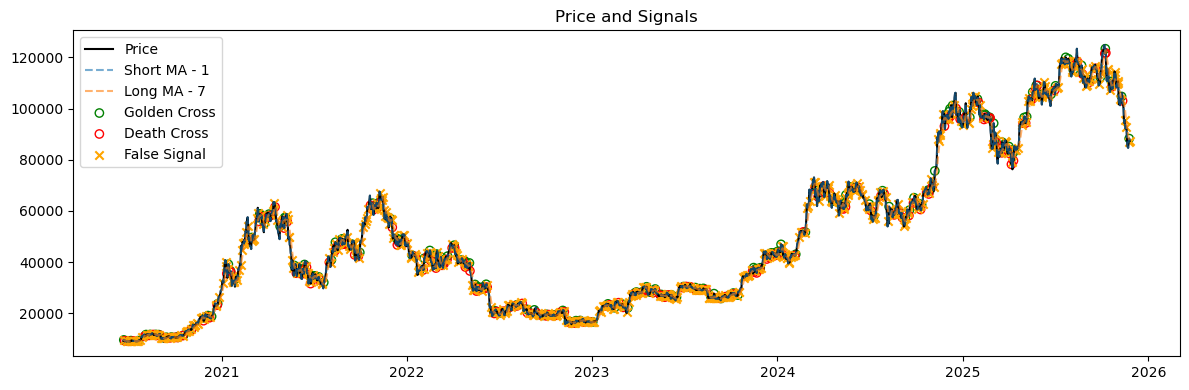

{'Summary':                      count      mean    median
MA Signal Trend                               
Buy       Downtrend    328 -0.010609 -0.007479
          Uptrend      718  0.025901  0.018634
Hold      Uptrend        1  0.000000  0.000000
Sell      Downtrend    646  0.024394  0.017584
          Uptrend      291 -0.013072 -0.008560, 'Dataframe':                    Price      Trend      Short_MA       Long_MA MA Signal  \
Date                                                                        
2020-06-21  9,303.629883    Uptrend  9,303.629883  9,303.629883      Hold   
2020-06-22  9,648.717773    Uptrend  9,648.717773  9,476.173828       Buy   
2020-06-23  9,629.658203  Downtrend  9,629.658203  9,527.335286       Buy   
2020-06-24  9,313.610352  Downtrend  9,313.610352  9,473.904053      Sell   
2020-06-25  9,264.813477  Downtrend  9,264.813477  9,432.085938      Sell   
...                  ...        ...           ...           ...       ...   
2025-11-21 85,090.687500  Dow

In [17]:
print(metr_ma_crx_v2(data=df_wkd1[["BTC-USD"]], start_date=df.index[-1] - pd.DateOffset(years=5, months=5, days=4), end_date=df.index[-1],
     ma_upp=7, ma_lwr=1, plot=True))   

In [18]:
# Start timer
start_time = time.time()

# Define dats
dats = [df[["SSW.JO"]], df[["PPE.JO"]], df_etf[["SPY"]], df_etf[["^TYX"]], df_etf[["EZA"]], df_wkd[["USDZAR=X"]], 
        df_wkd1[["BTC-USD"]], df_gld[["GC=F"]]]

# Define date ranges
starts = [
    df.index[-1] - pd.DateOffset(years=5, months=5, days=4),
    df.index[-1] - pd.DateOffset(years=5, months=0),
    df.index[-1] - pd.DateOffset(years=1, months=0),
    df.index[-1] - pd.DateOffset(years=0, months=10, days=4), 
    df.index[-1] - pd.DateOffset(years=0, months=6),
    df.index[-1] - pd.DateOffset(years=0, months=3),
    df.index[-1] - pd.DateOffset(years=0, months=1),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=14),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=7)]

ends = [df.index[-1]]

# Other hyperparameters
MA_lwrs = [1, 5, 7]
MA_upps = [7, 10, 14]

# Define parameter grid
param_grid = list(itertools.product(
    dats, starts, ends, MA_lwrs, MA_upps))

results = []
best_score = float('-inf')
less_score = float('inf')
best_params = None
less_params = None

best_rat = float('-inf')
less_rat = float('inf')
best_params_rat = None
less_params_rat = None

def evaluate_params(params):
    dat, start, end, MA_lwr, MA_upp = params

    if end <= start or MA_upp <= MA_lwr or (end.date() - start.date()).days <= MA_upp:
        return None

    try:
        f_summ = metr_ma_crx_v2(data=dat, start_date=start, end_date=end, ma_upp=MA_upp, ma_lwr=MA_lwr,
                                       plot=False)
        
        return {
            'Data': dat.columns[0],
            'Start': start,
            'End': end,
            'MA_lwr': MA_lwr,
            'MA_upp': MA_upp,
            'Win/Loss_Ratio': f_summ['Win/Loss_Ratio'],
            'Total Return (%)': f_summ['Total Return (%)']}

    except Exception as e:
        print(f"Error for {dat.columns[0]}, {start}, {end}, {MA_lwr}, {MA_upp}: {e}")
        return None

# Run grid search with progress bar and parallel execution
with ThreadPoolExecutor() as executor:
    for result in tqdm(executor.map(evaluate_params, param_grid), total=len(param_grid)):
        if result:
            results.append(result)
            score = result['Total Return (%)']
            rat = result['Win/Loss_Ratio']
            if score > best_score:
                best_score = score
                best_params = result
            elif score < less_score:
                less_score = score
                less_params = result
                
            if rat > best_rat:
                best_rat = rat
                best_params_rat = result
            elif rat < less_rat:
                less_rat = rat
                less_params_rat = result

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Output best and worst results
if best_params:
    print("\nBest combination on price found:")
    print(best_params)
    print(f"Avg Price Gained: {best_score:.2f}")

if less_params:
    print("\nWorst combination on price found:")
    print(less_params)
    print(f"Avg Price Lost: {less_score:.2f}")

if best_params_rat:
    print("\nBest combination on ratio found:")
    print(best_params_rat)
    print(f"Best Win/Loss ratio: {best_rat:.4f}")

if less_params_rat:
    print("\nWorst combination on ratio found:")
    print(less_params_rat)
    print(f"Worst Win/Loss ratio: {less_rat:.4f}")

# Total runtime
end_time = time.time()
print(f"\nTotal Run Time: {(end_time - start_time)/60:.2f} minutes")

100%|██████████| 648/648 [00:31<00:00, 20.77it/s]


Best combination on price found:
{'Data': 'BTC-USD', 'Start': Timestamp('2020-06-21 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'MA_lwr': 1, 'MA_upp': 7, 'Win/Loss_Ratio': 2.2052, 'Total Return (%)': 27.0711}
Avg Price Gained: 27.07

Worst combination on price found:
{'Data': 'SSW.JO', 'Start': Timestamp('2025-10-25 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'MA_lwr': 5, 'MA_upp': 7, 'Win/Loss_Ratio': 0.8333, 'Total Return (%)': -0.3235}
Avg Price Lost: -0.32

Best combination on ratio found:
{'Data': 'SSW.JO', 'Start': Timestamp('2025-11-11 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'MA_lwr': 7, 'MA_upp': 10, 'Win/Loss_Ratio': 4.5, 'Total Return (%)': -0.0136}
Best Win/Loss ratio: 4.5000

Worst combination on ratio found:
{'Data': 'SPY', 'Start': Timestamp('2025-10-25 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'MA_lwr': 5, 'MA_upp': 10, 'Win/Loss_Ratio': 0.6923, 'Total Return (%)': -0.0426}
Worst Win/Loss ratio: 0.6923

Total Run Time: 0.53 minu

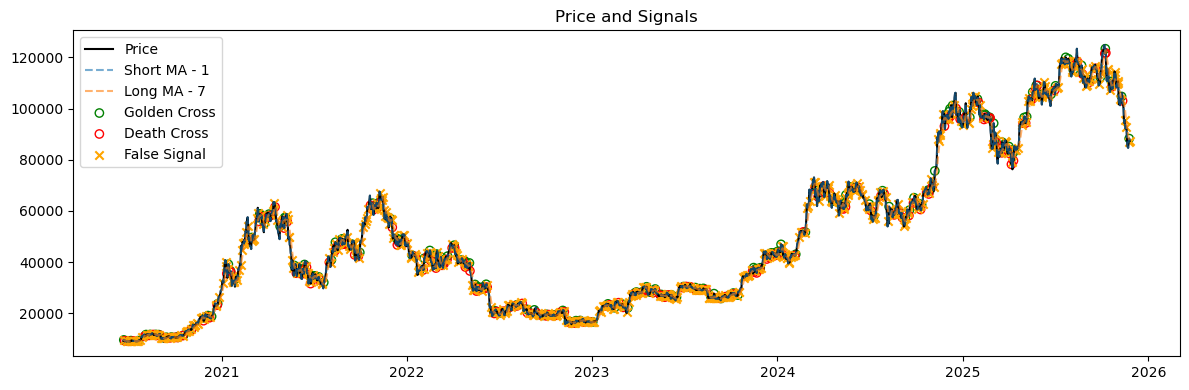

{'Summary':                      count      mean    median
 MA Signal Trend                               
 Buy       Downtrend    328 -0.010609 -0.007479
           Uptrend      718  0.025901  0.018634
 Hold      Uptrend        1  0.000000  0.000000
 Sell      Downtrend    646  0.024394  0.017584
           Uptrend      291 -0.013072 -0.008560,
 'Dataframe':                    Price      Trend      Short_MA       Long_MA MA Signal  \
 Date                                                                        
 2020-06-21  9,303.629883    Uptrend  9,303.629883  9,303.629883      Hold   
 2020-06-22  9,648.717773    Uptrend  9,648.717773  9,476.173828       Buy   
 2020-06-23  9,629.658203  Downtrend  9,629.658203  9,527.335286       Buy   
 2020-06-24  9,313.610352  Downtrend  9,313.610352  9,473.904053      Sell   
 2020-06-25  9,264.813477  Downtrend  9,264.813477  9,432.085938      Sell   
 ...                  ...        ...           ...           ...       ...   
 2025-11-21 85,

In [19]:
##Best combination  
metr_ma_crx_v2(data=df_wkd1[["BTC-USD"]], start_date=best_params['Start'], end_date=best_params['End'], ma_upp=best_params['MA_upp'], 
               ma_lwr=best_params['MA_lwr'], plot=True)

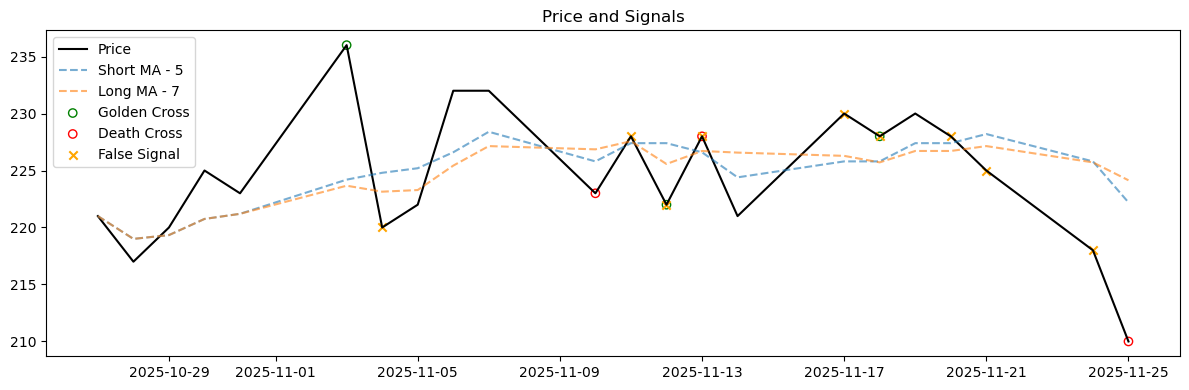

{'Summary':                      count      mean    median
 MA Signal Trend                               
 Buy       Downtrend      6 -0.025962 -0.019737
           Uptrend        5  0.024241  0.009091
 Hold      Downtrend      2  0.000000  0.000000
           Uptrend        3  0.000000  0.000000
 Sell      Downtrend      3  0.035397  0.036697
           Uptrend        3 -0.030058 -0.027027,
 'Dataframe':                 Price      Trend   Short_MA    Long_MA MA Signal  Return (%)  \
 Date                                                                           
 2025-10-27 221.000000    Uptrend 221.000000 221.000000      Hold    0.000000   
 2025-10-28 217.000000  Downtrend 219.000000 219.000000      Hold    0.000000   
 2025-10-29 220.000000    Uptrend 219.333333 219.333333      Hold    0.000000   
 2025-10-30 225.000000    Uptrend 220.750000 220.750000      Hold    0.000000   
 2025-10-31 223.000000  Downtrend 221.200000 221.200000      Hold    0.000000   
 2025-11-03 236.000000  

In [20]:
##Worst combination  
metr_ma_crx_v2(data=df[["PPE.JO"]], start_date=less_params['Start'], end_date=less_params['End'], ma_upp=less_params['MA_upp'], 
               ma_lwr=less_params['MA_lwr'], plot=True)

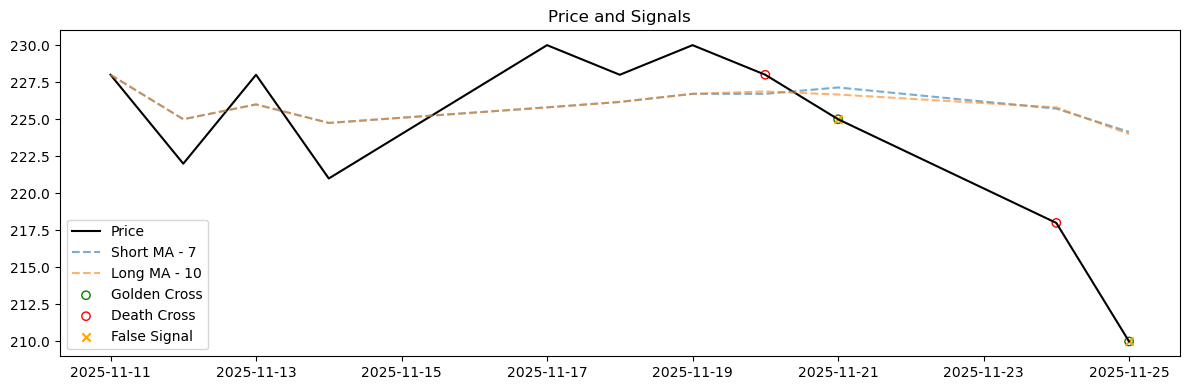

{'Summary':                      count      mean    median
 MA Signal Trend                               
 Buy       Downtrend      2 -0.024928 -0.024928
 Hold      Downtrend      3  0.000000  0.000000
           Uptrend        4  0.000000  0.000000
 Sell      Downtrend      2  0.019903  0.019903,
 'Dataframe':                 Price      Trend   Short_MA    Long_MA MA Signal  Return (%)  \
 Date                                                                           
 2025-11-11 228.000000    Uptrend 228.000000 228.000000      Hold    0.000000   
 2025-11-12 222.000000  Downtrend 225.000000 225.000000      Hold    0.000000   
 2025-11-13 228.000000    Uptrend 226.000000 226.000000      Hold    0.000000   
 2025-11-14 221.000000  Downtrend 224.750000 224.750000      Hold    0.000000   
 2025-11-17 230.000000    Uptrend 225.800000 225.800000      Hold    0.000000   
 2025-11-18 228.000000  Downtrend 226.166667 226.166667      Hold    0.000000   
 2025-11-19 230.000000    Uptrend 226.7

In [21]:
##Best combination (on Win/Loss ratio) 
metr_ma_crx_v2(data=df[["PPE.JO"]], start_date=best_params_rat['Start'], end_date=best_params_rat['End'], ma_upp=best_params_rat['MA_upp'], 
               ma_lwr=best_params_rat['MA_lwr'], plot=True)

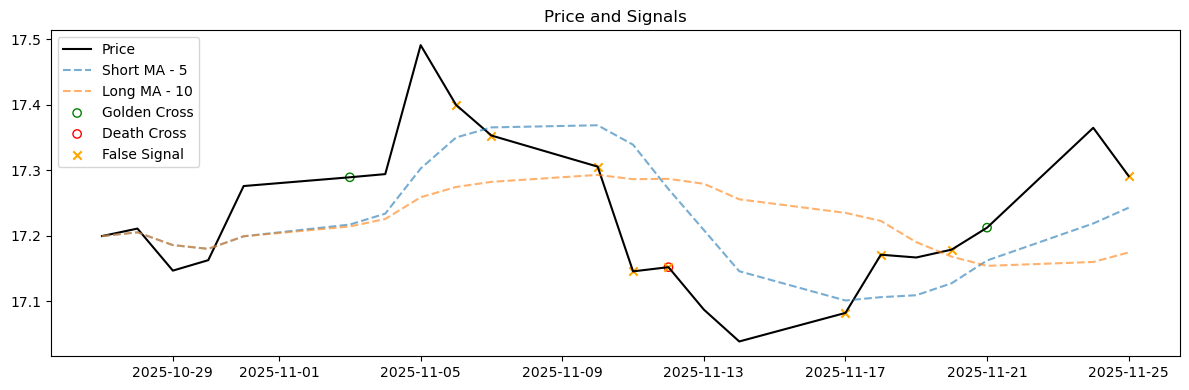

{'Summary':                      count      mean    median
 MA Signal Trend                               
 Buy       Downtrend      5 -0.004825 -0.004241
           Uptrend        5  0.004651  0.001953
 Hold      Downtrend      1  0.000000  0.000000
           Uptrend        4  0.000000  0.000000
 Sell      Downtrend      3  0.002291  0.002848
           Uptrend        4 -0.002209 -0.001629,
 'Dataframe':                Price      Trend  Short_MA   Long_MA MA Signal  Return (%)  \
 Date                                                                        
 2025-10-27 17.199499    Uptrend 17.199499 17.199499      Hold    0.000000   
 2025-10-28 17.210930    Uptrend 17.205215 17.205215      Hold    0.000000   
 2025-10-29 17.146749  Downtrend 17.185726 17.185726      Hold    0.000000   
 2025-10-30 17.162701    Uptrend 17.179970 17.179970      Hold    0.000000   
 2025-10-31 17.275890    Uptrend 17.199154 17.199154      Hold    0.000000   
 2025-11-03 17.289280    Uptrend 17.217110 17

In [22]:
##Worst combination (on Win/Loss ratio) 
metr_ma_crx_v2(data=df_wkd[["USDZAR=X"]], start_date=less_params_rat['Start'], end_date=less_params_rat['End'], ma_upp=less_params_rat['MA_upp'], 
               ma_lwr=less_params_rat['MA_lwr'], plot=True)

In [23]:
#Analysis
results_max = results_df
print(results_max.sort_values(by='Total Return (%)', ascending=False).dropna())

# Descriptive statistics
print("Descriptive Statistics for Total Return (%):")
print(results_max['Total Return (%)'].describe())

# Group-wise average scores by Data
group_summary = results_max.groupby(['Data'])['Total Return (%)'].mean().reset_index()

print("\n Parameter Combinations by Data:")
print(group_summary.sort_values(by='Total Return (%)', ascending=False))

# By Moving Averages
group_summary = results_max.groupby(['MA_lwr', 'MA_upp'])['Total Return (%)'].mean().reset_index()

print("\nTop Parameter Combinations by MA:")
print(group_summary.sort_values(by='Total Return (%)', ascending=False))

        Data      Start        End  MA_lwr  MA_upp  Win/Loss_Ratio  \
366  BTC-USD 2020-06-21 2025-11-25       1       7        2.205200   
374  BTC-USD 2020-11-25 2025-11-25       1       7        2.210900   
367  BTC-USD 2020-06-21 2025-11-25       1      10        1.846500   
0     SSW.JO 2020-06-21 2025-11-25       1       7        2.636400   
375  BTC-USD 2020-11-25 2025-11-25       1      10        1.863600   
..       ...        ...        ...     ...     ...             ...   
59    SSW.JO 2025-11-11 2025-11-25       5      10        1.750000   
298      EZA 2025-10-25 2025-11-25       7      10        1.200000   
283      EZA 2025-05-25 2025-11-25       7      14        1.031700   
58    SSW.JO 2025-11-11 2025-11-25       5       7        1.200000   
51    SSW.JO 2025-10-25 2025-11-25       5       7        0.833300   

     Total Return (%)  
366         27.071100  
374         25.404900  
367         23.209600  
0           22.523700  
375         21.945700  
..             

## Conclusion




Write Analysis!

# Bollinger Bands

Bollinger Bands consist of three lines plotted on a price chart:
- Middle Band: A simple moving average (SMA), usually a 20-period.
- Upper Band: The SMA plus two standard deviations.
- Lower Band: The SMA minus two standard deviations.
  
These bands expand and contract based on market volatility; they widen during high volatility and narrow during low volatility. Used to identify overbought or oversold conditions in the market.

Interpreting Bollinger Bands Signals:
- Overbought Conditions: When the price touches or exceeds the upper band, indicates the asset is overbought, suggesting a sell signal.
- Oversold Conditions: When the price touches or falls below the lower band, indicates the asset is oversold, suggesting a buy signal.
- Volatility Breakouts: A squeeze (when the bands come close together) often precedes significant price movements, indicating potential breakout opportunities.

Trading Strategies with Bollinger Bands:
- Trend Following: Use bands to identify the direction of the trend. If the price consistently stays above the middle band, it indicates an uptrend, while staying below indicates a downtrend.
- Mean Reversion: Look for price reversals when the price touches the upper or lower bands, betting the price will revert to the mean (the middle band). 

In [24]:
def calculate_bollinger_bands(data, window, num_std):
    if len(data) < window: 
        raise ValueError("Not enough data points for the given window size.")
    
    sma = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()

    #Add Lower & Upper Bands
    upper_band = sma + (rolling_std * num_std)
    lower_band = sma - (rolling_std * num_std)
    
    #Create Dataframe
    bands = pd.DataFrame({
        'Price': data, #.squeeze(),
        'SMA': sma,
        'Upper Band': upper_band,
        'Lower Band': lower_band})

    #Position Signal
    bands['Signal'] = np.select([ (bands['Price'] >= bands['Upper Band']) ,
        (bands['Price'] <= bands['Lower Band'])], ['Sell', 'Buy'], default='None')

    #Position
    bands['Position'] = bands['Signal'].replace('None', pd.NA).ffill()
    bands['Position'] = bands['Position'].replace(pd.NA, 'None')

    #Trend Signal
    bands['Trend'] = np.select([ (bands['Price'] > bands['SMA']) ,
        (bands['Price'] < bands['SMA'])], ['Uptrend', 'Downtrend'], default='None')
    bands['Trend'] = bands['Trend'].replace('None', pd.NA).ffill()
    bands['Trend'] = bands['Trend'].replace(pd.NA, 'None')
    
    return bands

In [25]:
def metr_bb_v2(data, start_date, end_date, window, num_std, plot=True):
    # Datetime index and proper slicing
    data = data.loc[start_date:end_date].sort_index()
    
    bands = calculate_bollinger_bands(data, window=window, num_std=num_std)
    bands['Return (%)'] = np.where(bands['Position'] == 'Buy', bands['Price'].pct_change(), 
                             np.where(bands['Position'] == 'Sell', -bands['Price'].pct_change(), 0)) 

    # False Signals
    bands['False_Signal'] = np.where((bands['Position'] == 'Buy') & (bands['Price'].pct_change()<0), 1,
                                    np.where((bands['Position'] == 'Sell') & (bands['Price'].pct_change()>0), 1, 0))

    # Additional Metrics
    strategy_pct_gain = (bands['Return (%)'].add(1).prod())-1
    if (bands['False_Signal']==1).sum()>0:
        win_loss_rat = (bands['False_Signal']==0).sum() / (bands['False_Signal']==1).sum()
    else:
        win_loss_rat = 2

    # Performance Summary
    summary = bands.groupby(['Position', 'Trend'])['Return (%)'].agg(['count', 'mean', 'median'])
          
    if plot:
        fig, axes = plt.subplots(figsize=(12, 4))
        axes.plot(data.index, data, label='Close Price', color='black')
        axes.plot(data.index, bands['SMA'], label='SMA', color='orange')
        axes.plot(data.index, bands['Upper Band'], label='Upper Band', color='blue')
        axes.plot(data.index, bands['Lower Band'], label='Lower Band', color='purple')
        axes.fill_between(data.index, bands['Lower Band'], bands['Upper Band'], color='gray', alpha=0.1)

        #Trade Points
        buy_points = bands[bands['Signal'] == 'Buy'].index
        sell_points = bands[bands['Signal'] == 'Sell'].index

        axes.scatter(buy_points, data.loc[buy_points], color='green', marker='^', label='Buy Signal')
        axes.scatter(sell_points, data.loc[sell_points], color='red', marker='v', label='Sell Signal')

        fs_points = bands[bands['False_Signal'] == 1].index
        axes.scatter(fs_points, bands.loc[fs_points, 'Price'], color='yellow', marker='x', label='False Signal')
        
        axes.set_title('Bollinger Bands')
        axes.set_xlabel('Date')
        axes.set_ylabel('Price')
        axes.legend()
        plt.show()
        
    return {'Summary': summary, 'Dataframe': bands, 'Win/Loss_Ratio': win_loss_rat, 'Total Return (%)': np.round(strategy_pct_gain*100, 4)}

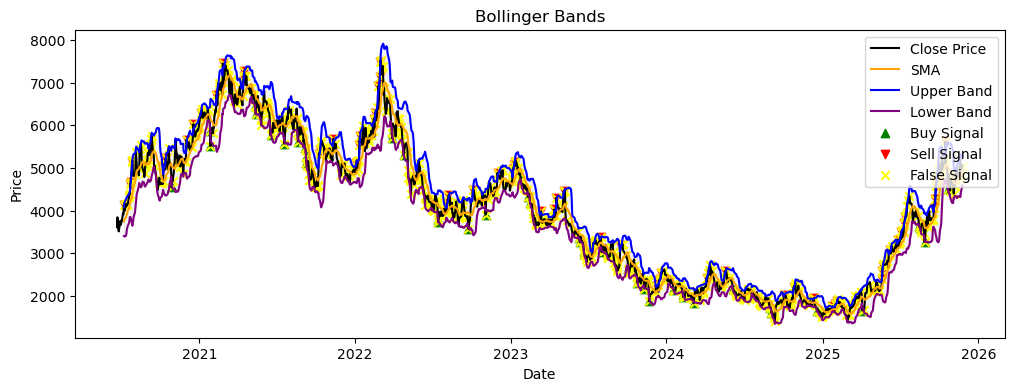

{'Summary':                     count      mean    median
 Position Trend                               
 Buy      Downtrend    406 -0.010049 -0.010463
          Uptrend      224  0.014022  0.011195
 None     None          12  0.000000  0.000000
 Sell     Downtrend    283  0.011086  0.009568
          Uptrend      435 -0.011770 -0.009605,
 'Dataframe':                   Price          SMA   Upper Band   Lower Band Signal  \
 Date                                                                    
 2020-06-22 3,611.918457          NaN          NaN          NaN   None   
 2020-06-23 3,841.405029          NaN          NaN          NaN   None   
 2020-06-24 3,591.963623          NaN          NaN          NaN   None   
 2020-06-25 3,561.032227          NaN          NaN          NaN   None   
 2020-06-26 3,510.146240          NaN          NaN          NaN   None   
 ...                 ...          ...          ...          ...    ...   
 2025-11-19 5,138.000000 4,778.538462 5,228.939479 4,3

In [26]:
metr_bb_v2(data=df["SSW.JO"], start_date=df.index[-1] - pd.DateOffset(years=5, months=5, days=4), end_date=df.index[-1], window=13, 
           num_std=2, plot=True)

In [27]:
# Start timer
start_time = time.time()

# Define dats
dats = [df["SSW.JO"], df["PPE.JO"], df_etf["SPY"], df_etf["^TYX"], df_etf["EZA"], df_wkd["USDZAR=X"], df_wkd1["BTC-USD"], df_gld["GC=F"]]

# Define date ranges
starts = [
    df.index[-1] - pd.DateOffset(years=5, months=5, days=4),
    df.index[-1] - pd.DateOffset(years=5, months=0),
    df.index[-1] - pd.DateOffset(years=1, months=0),
    df.index[-1] - pd.DateOffset(years=0, months=10, days=4), 
    df.index[-1] - pd.DateOffset(years=0, months=6),
    df.index[-1] - pd.DateOffset(years=0, months=3),
    df.index[-1] - pd.DateOffset(years=0, months=1),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=14),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=7)]

ends = [df.index[-1]]

# Other hyperparameters
windows = [13, 20, 37]
num_stds = [2, 10, 14]

# Define parameter grid
param_grid = list(itertools.product(
    dats, starts, ends, windows, num_stds))

results = []
best_score = float('-inf')
less_score = float('inf')
best_params = None
less_params = None

best_rat = float('-inf')
less_rat = float('inf')
best_params_rat = None
less_params_rat = None

def evaluate_params(params):
    dat, start, end, window, num_std = params

    if end <= start or len(pd.bdate_range(start, end))  < window: 
        return None

    try:
        f_dat = metr_bb_v2(data=dat, start_date=start, end_date=end, window=window, num_std=num_std, plot=False)
        
        return {
            'Data': dat.name,
            'Start': start,
            'End': end,
            'Window': window,
            'Standard Dev': num_std,
            'Win/Loss_Ratio': f_dat['Win/Loss_Ratio'],
            'Score': f_dat['Total Return (%)']}

    except Exception as e:
        print(f"Error for {dat.name}, {start}, {end}, {window}, {num_std}: {e}")
        return None

# Run grid search with progress bar and parallel execution
with ThreadPoolExecutor() as executor:
    for result in tqdm(executor.map(evaluate_params, param_grid), total=len(param_grid)):
        if result:
            results.append(result)
            score = result['Score']
            rat = result['Win/Loss_Ratio']
            if score > best_score:
                best_score = score
                best_params = result
            elif score < less_score:
                less_score = score
                less_params = result
                
            if rat > best_rat:
                best_rat = rat
                best_params_rat = result
            elif rat < less_rat:
                less_rat = rat
                less_params_rat = result

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Output best and worst results
if best_params:
    print("\nBest combination on price found:")
    print(best_params)
    print(f"Avg Price (%) Gained: {best_score:.2f}")

if less_params:
    print("\nWorst combination on price found:")
    print(less_params)
    print(f"Avg Price (%) Lost: {less_score:.2f}")

if best_params_rat:
    print("\nBest combination on ratio found:")
    print(best_params_rat)
    print(f"Best Win/Loss ratio: {best_rat:.4f}")

if less_params_rat:
    print("\nWorst combination on ratio found:")
    print(less_params_rat)
    print(f"Worst Win/Loss ratio: {less_rat:.4f}")

# Total runtime
end_time = time.time()
print(f"\nTotal Run Time: {(end_time - start_time)/60:.2f} minutes")

100%|██████████| 648/648 [00:13<00:00, 47.53it/s]


Best combination on price found:
{'Data': 'USDZAR=X', 'Start': Timestamp('2025-01-21 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'Window': 37, 'Standard Dev': 2, 'Win/Loss_Ratio': 1.6071428571428572, 'Score': 15.3293}
Avg Price (%) Gained: 15.33

Worst combination on price found:
{'Data': 'BTC-USD', 'Start': Timestamp('2020-06-21 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'Window': 13, 'Standard Dev': 2, 'Win/Loss_Ratio': 0.9280855199222546, 'Score': -99.9873}
Avg Price (%) Lost: -99.99

Best combination on ratio found:
{'Data': 'PPE.JO', 'Start': Timestamp('2025-08-25 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'Window': 37, 'Standard Dev': 2, 'Win/Loss_Ratio': 65.0, 'Score': -3.6697}
Best Win/Loss ratio: 65.0000

Worst combination on ratio found:
{'Data': 'GC=F', 'Start': Timestamp('2020-11-25 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'Window': 13, 'Standard Dev': 2, 'Win/Loss_Ratio': 0.8649851632047477, 'Score': -76.3067}
Worst Win/Loss ratio:

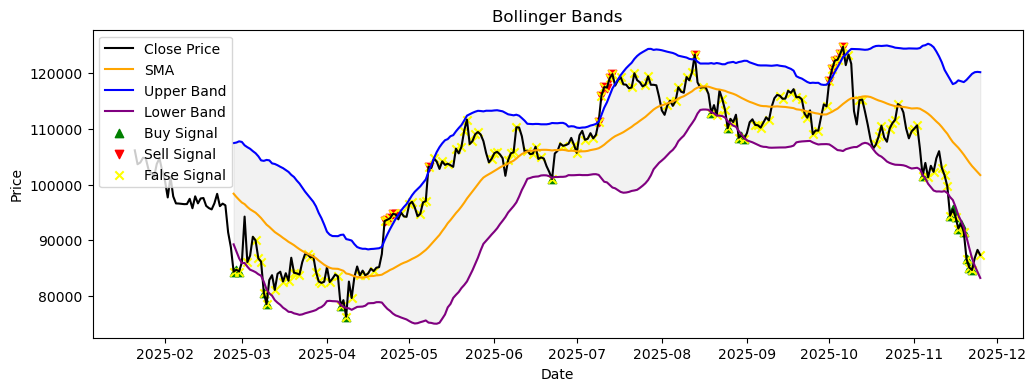

{'Summary':                     count      mean    median
 Position Trend                               
 Buy      Downtrend     99 -0.002611 -0.003853
          Uptrend       38  0.003549  0.002706
 None     None          36  0.000000  0.000000
 Sell     Downtrend     40  0.006452  0.007133
          Uptrend       96 -0.004521 -0.002273,
 'Dataframe':                     Price            SMA     Upper Band    Lower Band Signal  \
 Date                                                                           
 2025-01-21 106,146.265625            NaN            NaN           NaN   None   
 2025-01-22 103,653.070312            NaN            NaN           NaN   None   
 2025-01-23 103,960.171875            NaN            NaN           NaN   None   
 2025-01-24 104,819.484375            NaN            NaN           NaN   None   
 2025-01-25 104,714.648438            NaN            NaN           NaN   None   
 ...                   ...            ...            ...           ...    ...  

In [28]:
##Best combination
metr_bb_v2(data=df_wkd1["BTC-USD"], start_date=best_params['Start'], end_date=best_params['End'],
                                  window=best_params['Window'], num_std=best_params['Standard Dev'], plot=True)

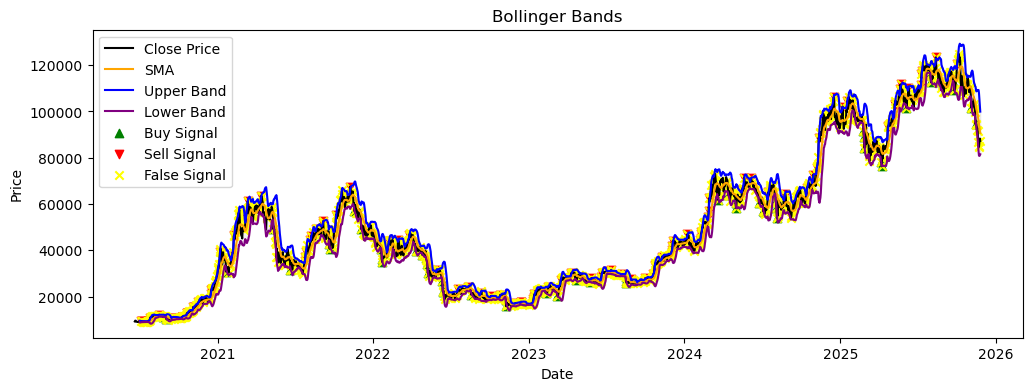

{'Summary':                     count      mean    median
 Position Trend                               
 Buy      Downtrend    502 -0.009143 -0.005135
          Uptrend      155  0.013998  0.011359
 None     Downtrend      3  0.000000  0.000000
          None          12  0.000000  0.000000
 Sell     Downtrend    425  0.009365  0.005833
          Uptrend      887 -0.010807 -0.005973,
 'Dataframe':                    Price           SMA     Upper Band    Lower Band Signal  \
 Date                                                                         
 2020-06-21  9,303.629883           NaN            NaN           NaN   None   
 2020-06-22  9,648.717773           NaN            NaN           NaN   None   
 2020-06-23  9,629.658203           NaN            NaN           NaN   None   
 2020-06-24  9,313.610352           NaN            NaN           NaN   None   
 2020-06-25  9,264.813477           NaN            NaN           NaN   None   
 ...                  ...           ...       

In [29]:
##Worst combination  
metr_bb_v2(data=df_wkd1["BTC-USD"], start_date=less_params['Start'], end_date=less_params['End'],
                                  window=less_params['Window'], num_std=less_params['Standard Dev'], plot=True)

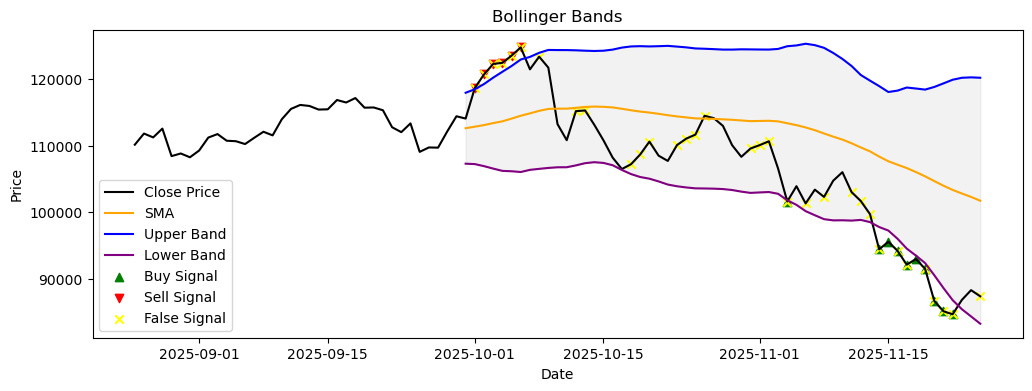

{'Summary':                     count      mean    median
 Position Trend                               
 Buy      Downtrend     22 -0.008708 -0.011751
 None     None          36  0.000000  0.000000
          Uptrend        1  0.000000  0.000000
 Sell     Downtrend     23  0.006458  0.007267
          Uptrend       11 -0.008079 -0.010032,
 'Dataframe':                     Price            SMA     Upper Band    Lower Band Signal  \
 Date                                                                           
 2025-08-25 110,124.351562            NaN            NaN           NaN   None   
 2025-08-26 111,802.656250            NaN            NaN           NaN   None   
 2025-08-27 111,222.062500            NaN            NaN           NaN   None   
 2025-08-28 112,544.804688            NaN            NaN           NaN   None   
 2025-08-29 108,410.835938            NaN            NaN           NaN   None   
 ...                   ...            ...            ...           ...    ...  

In [30]:
##Best combination (on Win/Loss ratio)
metr_bb_v2(data=df_wkd1["BTC-USD"], start_date=best_params_rat['Start'], end_date=best_params_rat['End'],
                                  window=best_params_rat['Window'], num_std=best_params_rat['Standard Dev'], plot=True)

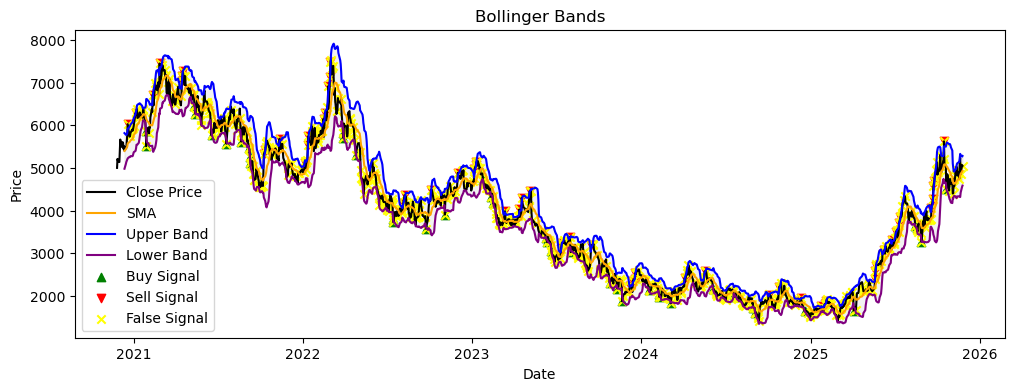

{'Summary':                     count      mean    median
 Position Trend                               
 Buy      Downtrend    396 -0.010131 -0.010463
          Uptrend      209  0.014126  0.011065
 None     None          12  0.000000  0.000000
          Uptrend        4  0.000000  0.000000
 Sell     Downtrend    256  0.011282  0.009471
          Uptrend      373 -0.012155 -0.009789,
 'Dataframe':                   Price          SMA   Upper Band   Lower Band Signal  \
 Date                                                                    
 2020-11-25 5,001.276855          NaN          NaN          NaN   None   
 2020-11-26 5,211.826172          NaN          NaN          NaN   None   
 2020-11-27 5,160.935547          NaN          NaN          NaN   None   
 2020-11-30 5,138.982422          NaN          NaN          NaN   None   
 2020-12-01 5,383.458008          NaN          NaN          NaN   None   
 ...                 ...          ...          ...          ...    ...   
 2025-1

In [31]:
##Worst combination (on Win/Loss ratio)
metr_bb_v2(data=df["SSW.JO"], start_date=less_params_rat['Start'], end_date=less_params_rat['End'],
                                  window=less_params_rat['Window'], num_std=less_params_rat['Standard Dev'], plot=True)

In [32]:
#Analysis
results_bb = results_df
# Print top results
print(results_df.sort_values(by='Score', ascending=False).dropna())

# Descriptive statistics
print("Descriptive Statistics for 'Score':")
print(results_bb['Score'].describe())

# Group-wise average scores by Data
group_summary = results_bb.groupby(['Data'])['Score'].mean().reset_index()

print("\n Parameter Combinations by Data:")
print(group_summary.sort_values(by='Score', ascending=False))

# By Window
group_summary = results_bb.groupby(['Window'])['Score'].mean().reset_index()

print("\nTop Parameter Combinations by Window:")
print(group_summary.sort_values(by='Score', ascending=False))

# By Standard Dev
group_summary = results_bb.groupby(['Standard Dev'])['Score'].mean().reset_index()

print("\nTop Parameter Combinations by Standard Dev:")
print(group_summary.sort_values(by='Score', ascending=False))

         Data      Start        End  Window  Standard Dev  Win/Loss_Ratio  \
333  USDZAR=X 2025-01-21 2025-11-25      37             2        1.607143   
207      ^TYX 2025-01-21 2025-11-25      13             2        1.443182   
324  USDZAR=X 2024-11-25 2025-11-25      37             2        1.376147   
342  USDZAR=X 2025-05-25 2025-11-25      37             2        2.666667   
273       EZA 2025-01-21 2025-11-25      37             2        1.529412   
..        ...        ...        ...     ...           ...             ...   
366   BTC-USD 2020-06-21 2025-11-25      37             2        0.985986   
372   BTC-USD 2020-11-25 2025-11-25      20             2        0.960300   
363   BTC-USD 2020-06-21 2025-11-25      20             2        0.948919   
369   BTC-USD 2020-11-25 2025-11-25      13             2        0.956103   
360   BTC-USD 2020-06-21 2025-11-25      13             2        0.928086   

         Score  
333  15.329300  
207  13.967300  
324  10.534100  
342   5

## Conclusion

Here

# Moving Average Convergence/Divergence Oscillator (MACD)

MACD uses two Moving Averages of varying lengths (i.e. lagging indicators) to identify trend direction and duration. Then takes the difference in values between those two Moving Averages (MACD Line) and an EMA of those Moving Averages (Signal Line) and plots that difference between the two lines as a histogram which oscillates above and below a center Zero Line. 
The histogram is used as a good indication of a security's momentum.

Interpretation: When MACD is positive and histogram value is increasing, then upside momentum is increasing. When MACD is negative and histogram value is decreasing, then downside momentum is increasing.

Good for identifying 3 types of signals:

    i) Signal Line Crossovers - Bullish Signal Line Crossovers occur when MACD Line crosses above Signal Line.
                              - Bearish Signal Line Crossovers occur when MACD Line crosses below Signal Line.

    ii) Zero Line Crossovers - Bullish Zero Line Crossovers occur when MACD Line goes from negative to positive.
                             - Bearish Zero Line Crossovers occur when MACD Line goes from positive to negative.

    iii) Divergence - Bullish Divergence occurs when price records a lower low, but MACD records a higher low.
                    - Bearish Divergence occurs when price records a higher high while MACD records a lower high.

In [33]:
# Function to calculate MACD and Signal Line
def calculate_macd(prices, short_window, long_window, signal_window):
    #MACD calculation
    short_ema = prices.ewm(span=short_window, adjust=False).mean() # Short-term EMA
    long_ema = prices.ewm(span=long_window, adjust=False).mean() # Long-term EMA
    macd_line = short_ema - long_ema # MACD Line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean() # Signal Line
    hist = macd_line - signal_line # Histogram

    macd_df = pd.DataFrame({'Prices': prices, 'MACD': macd_line, 'Signal': signal_line, 'Histogram': hist})
    macd_df['Price_Change'] = macd_df['Prices'].pct_change()
    macd_df['MACD_Change'] = macd_df['MACD'].diff()
    
    # (1) Detect Signal Line Crossover
    macd_df['TSignal_Crossover'] = np.where((macd_df['MACD'].shift(1) < macd_df['Signal'].shift(1)) & (macd_df['MACD'] > macd_df['Signal']),
        'Bullish', np.where((macd_df['MACD'].shift(1) > macd_df['Signal'].shift(1)) & (macd_df['MACD'] < macd_df['Signal']),
            'Bearish', None))
    macd_df['Position'] = macd_df['TSignal_Crossover'].replace('None', pd.NA).ffill()
    macd_df['Position'] = macd_df['Position'].replace(pd.NA, 'None')
    macd_df['Signal_Crossover'] = macd_df['Position']

    # (2) Detect Zero Line Crossover
    macd_df['TZero_Crossover'] = np.where((macd_df['MACD'].shift(1) < 0) & (macd_df['MACD'] > 0), 'Bullish',
        np.where((macd_df['MACD'].shift(1) > 0) & (macd_df['MACD'] < 0), 'Bearish', None))
    macd_df['Position'] = macd_df['TZero_Crossover'].replace('None', pd.NA).ffill()
    macd_df['Position'] = macd_df['Position'].replace(pd.NA, 'None')
    macd_df['Zero_Crossover'] = macd_df['Position']

    # (3) Detect Divergence
    macd_df['TDivergence'] = np.where((macd_df['Price_Change'] < 0) & (macd_df['MACD_Change'] > 0), 'Bullish',
        np.where((macd_df['Price_Change'] > 0) & (macd_df['MACD_Change'] < 0), 'Bearish', None))
    macd_df['Position'] = macd_df['TDivergence'].replace('None', pd.NA).ffill()
    macd_df['Position'] = macd_df['Position'].replace(pd.NA, 'None')
    macd_df['Divergence'] = macd_df['Position']

    macd_df['Trend'] = np.where((macd_df['Price_Change'] < 0) , 'Downtrend', 'Uptrend')

    return macd_df

In [34]:
def metr_macd_v4(prices, start_date, end_date, short_window, long_window, signal_window, plot=True):
    # Datetime index and proper slicing
    prices = prices.loc[start_date:end_date].sort_index()
    
    #MACD calculation
    macd_df = calculate_macd(prices, short_window, long_window, signal_window)
    macd_dfz = macd_df

    #Drop
    macd_dfz = macd_dfz.drop('Position', axis=1)
    macd_dfz = macd_dfz.drop('TSignal_Crossover', axis=1)
    macd_dfz = macd_dfz.drop('TZero_Crossover', axis=1)
    macd_dfz = macd_dfz.drop('TDivergence', axis=1)
    macd_dfz = macd_dfz.drop('MACD_Change', axis=1)
    
    # Performance testing
    ##Convert to numerics
    mapping = {'Bullish': 1, 'Bearish': -1, 'None': 0}
    macd_num = macd_df.replace(mapping)

    columns = [5,6,7]
    subsets = []

    for i in range(1, 4):
        comb = combinations(columns, i)
        subsets.extend(comb)

    for n in range(7):
        results = []
        avg = macd_num.iloc[ :, list(subsets[n])].mean(axis=1)
        macd_df.columns[list(subsets[n])]
        macd_dfz['Temp'] = np.select([ avg > 0, avg < 0], ['Bullish', 'Bearish'], default='None')
        macd_dfz['Temp'] = macd_dfz['Temp'].replace('None', pd.NA).ffill()
        signal = macd_dfz['Temp'].replace(pd.NA, 'None')
        #Drop
        macd_dfz = macd_dfz.drop('Temp', axis=1)
                
        bps_chng = np.where(signal == 'Bullish', macd_num['Price_Change'], -1* macd_num['Price_Change'])
        bps_chng = np.where(signal == 'None', 0, bps_chng)
        col_nam = macd_dfz.columns[list(subsets[n])]
        macd_dfz[f"bps_change {'_'.join(col_nam)}"] = bps_chng

    # Performance Summary   
    bps = macd_dfz.iloc[:, 9:17].sum()
    high_bps_nam = bps.idxmax()
    high_bps = bps.max()
    low_bps_nam = bps.idxmin()
    low_bps = bps.min()
     
    if plot:
        plt.figure(figsize=(12, 6))
        # Price Plot
        plt.subplot(2, 1, 1)
        plt.plot(macd_df.index, macd_df['Prices'], label='Price', color='black')
        
        plt.scatter(macd_df.index[macd_df['TSignal_Crossover'] == 'Bullish'],
                    macd_df['Prices'][macd_df['TSignal_Crossover'] == 'Bullish'], marker='^', color='green', label='Bullish Signal')
        plt.scatter(macd_df.index[macd_df['TSignal_Crossover'] == 'Bearish'],
                    macd_df['Prices'][macd_df['TSignal_Crossover'] == 'Bearish'], marker='v', color='red', label='Bearish Signal')

        plt.scatter(macd_df.index[macd_df['TZero_Crossover'] == 'Bullish'],
                    macd_df['Prices'][macd_df['TZero_Crossover'] == 'Bullish'], marker='^', color='yellow', label='Bullish Zero')
        plt.scatter(macd_df.index[macd_df['TZero_Crossover'] == 'Bearish'],
                    macd_df['Prices'][macd_df['TZero_Crossover'] == 'Bearish'], marker='v', color='purple', label='Bearish Zero')

        plt.scatter(macd_df.index[macd_df['TDivergence'] == 'Bullish'],
                    macd_df['Prices'][macd_df['TDivergence'] == 'Bullish'], marker='^', color='blue', label='Bullish Divergence')
        plt.scatter(macd_df.index[macd_df['TDivergence'] == 'Bearish'],
                    macd_df['Prices'][macd_df['TDivergence'] == 'Bearish'], marker='v', color='orange', label='Bearish Divergence')
        
        plt.title('Price and MACD for Stress-Tested Signals')
        plt.legend()
        plt.ylabel('Price')

        # MACD Plot
        plt.subplot(2, 1, 2)
        plt.plot(macd_df.index, macd_df['MACD'], label='MACD', color='blue')
        plt.plot(macd_df.index, macd_df['Signal'], label='Signal', color='orange')
        plt.bar(macd_df.index, macd_df['Histogram'], color='gray', label='Histogram')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('MACD')

        plt.tight_layout()
        plt.show()
        
    return {'Dataframe':macd_dfz, 'Strategy Returns (%)': bps, 'Highest Strategy':high_bps_nam, 'Highest Returns': high_bps, 
                'Lowest Strategy':low_bps_nam, 'Lowest Returns': low_bps}

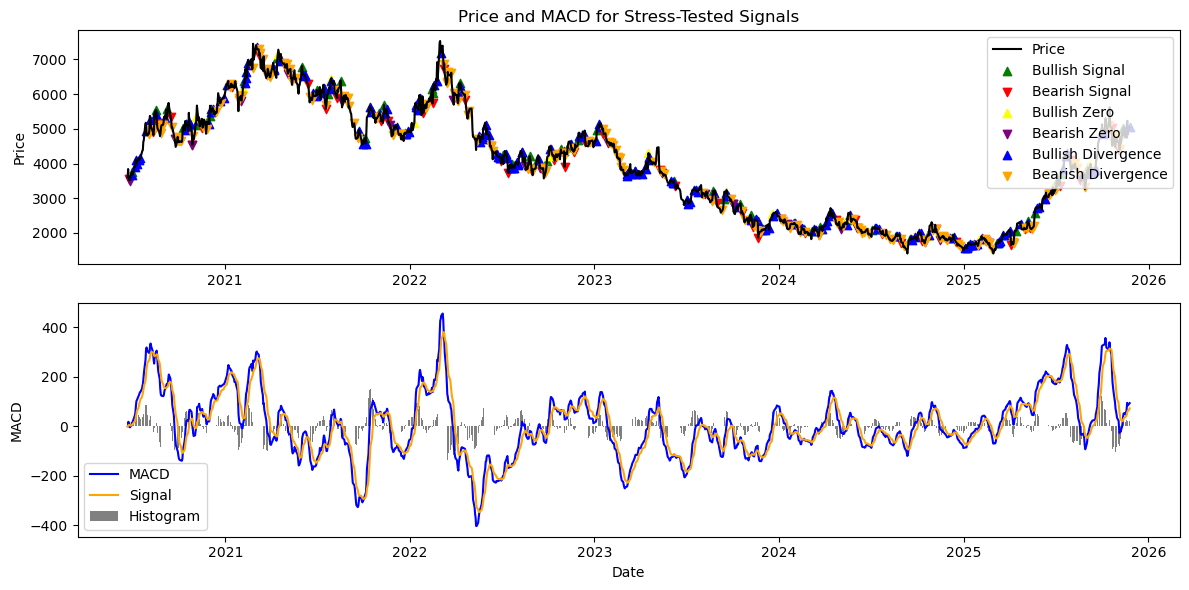

{'Dataframe':                  Prices      MACD    Signal  Histogram  Price_Change  \
 Date                                                                   
 2020-06-22 3,611.918457  0.000000  0.000000   0.000000           NaN   
 2020-06-23 3,841.405029 18.306621  3.661324  14.645297      0.063536   
 2020-06-24 3,591.963623 12.542333  5.437526   7.104807     -0.064935   
 2020-06-25 3,561.032227  5.415759  5.433173  -0.017414     -0.008611   
 2020-06-26 3,510.146240 -4.288739  3.488790  -7.777529     -0.014290   
 ...                 ...       ...       ...        ...           ...   
 2025-11-19 5,138.000000 69.448468 45.546364  23.902104      0.081684   
 2025-11-20 5,232.000000 94.542594 55.345610  39.196984      0.018295   
 2025-11-21 4,860.000000 83.450612 60.966610  22.484002     -0.071101   
 2025-11-24 5,068.000000 90.401901 66.853668  23.548233      0.042798   
 2025-11-25 5,050.000000 93.381949 72.159325  21.222625     -0.003552   
 
            Signal_Crossover Zero_Cr

In [35]:
metr_macd_v4(prices=df["SSW.JO"], start_date=df.index[-1] - pd.DateOffset(years=5, months=5, days=4), end_date=df.index[-1], 
             short_window=12, long_window=26, signal_window=9, plot=True)

In [36]:
# Start timer
start_time = time.time()

# Define dats
dats = [df["SSW.JO"], df["PPE.JO"], df_etf["SPY"], df_etf["^TYX"], df_etf["EZA"], df_wkd["USDZAR=X"], df_wkd1["BTC-USD"], df_gld["GC=F"]]

# Define date ranges
starts = [
    df.index[-1] - pd.DateOffset(years=5, months=5, days=4),
    df.index[-1] - pd.DateOffset(years=5, months=0),
    df.index[-1] - pd.DateOffset(years=1, months=0),
    df.index[-1] - pd.DateOffset(years=0, months=10, days=4), 
    df.index[-1] - pd.DateOffset(years=0, months=6),
    df.index[-1] - pd.DateOffset(years=0, months=3),
    df.index[-1] - pd.DateOffset(years=0, months=1),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=14),
    df.index[-1] - pd.DateOffset(years=0, months=0, days=7)]

ends = [df.index[-1]]

# Other hyperparameters
short_windows = [13, 20, 37]
long_windows = [40, 50, 60]
signal_windows = [2, 10, 14]

# Define parameter grid
param_grid = list(itertools.product(
    dats, starts, ends, short_windows, long_windows, signal_windows))

results = []
best_score = float('-inf')
less_score = float('inf')
best_params = None
less_params = None

best_rat = float('-inf')
less_rat = float('inf')
best_params_rat = None
less_params_rat = None

def evaluate_params(params):
    dat, start, end, short_window, long_window, signal_window = params

    if end <= start or len(pd.bdate_range(start, end))  < short_window: 
        return None

    try:
        f_summ = metr_macd_v4(prices=dat, start_date=start, end_date=end, short_window=short_window,
                                            long_window=long_window, signal_window=signal_window, plot=False)
        
        return {
            'Data': dat.name,
            'Start': start,
            'End': end,
            'Short Window': short_window,
            'Long Window': long_window,
            'Signal Window': signal_window,
            'Highest Strategy': f_summ['Highest Strategy'],
            'HScore': f_summ['Highest Returns'],
            'Lowest Strategy': f_summ['Lowest Strategy'],
            'LScore': f_summ['Lowest Returns']}

    except Exception as e:
        print(f"Error for {dat.name}, {start}, {end}, {short_window}, {long_window}, {signal_window}: {e}")
        return None

# Run grid search with progress bar and parallel execution
with ThreadPoolExecutor() as executor:
    for result in tqdm(executor.map(evaluate_params, param_grid), total=len(param_grid)):
        if result:
            results.append(result)
            hscore = result['HScore']
            lscore = result['LScore']
            if hscore > best_score:
                best_score = hscore
                best_params = result
            elif lscore < less_score:
                less_score = lscore
                less_params = result

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Output best and worst results
if best_params:
    print("\nBest combination on price found:")
    print(best_params)
    print(f"Avg Price Gained: {best_score:.2f}")

if less_params:
    print("\nWorst combination on price found:")
    print(less_params)
    print(f"Avg Price Lost: {less_score:.2f}")

# Total runtime
end_time = time.time()
print(f"\nTotal Run Time: {(end_time - start_time)/60:.2f} minutes")

100%|██████████| 1944/1944 [01:27<00:00, 22.23it/s]


Best combination on price found:
{'Data': 'BTC-USD', 'Start': Timestamp('2020-06-21 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'Short Window': 13, 'Long Window': 40, 'Signal Window': 2, 'Highest Strategy': 'bps_change Signal_Crossover', 'HScore': 23.18008987467402, 'Lowest Strategy': 'bps_change Divergence', 'LScore': -2.3499397722606163}
Avg Price Gained: 23.18

Worst combination on price found:
{'Data': 'SSW.JO', 'Start': Timestamp('2020-06-21 00:00:00'), 'End': Timestamp('2025-11-25 00:00:00'), 'Short Window': 20, 'Long Window': 60, 'Signal Window': 2, 'Highest Strategy': 'bps_change Signal_Crossover', 'HScore': 18.153216399309727, 'Lowest Strategy': 'bps_change Divergence', 'LScore': -5.553080927108354}
Avg Price Lost: -5.55

Total Run Time: 1.47 minutes


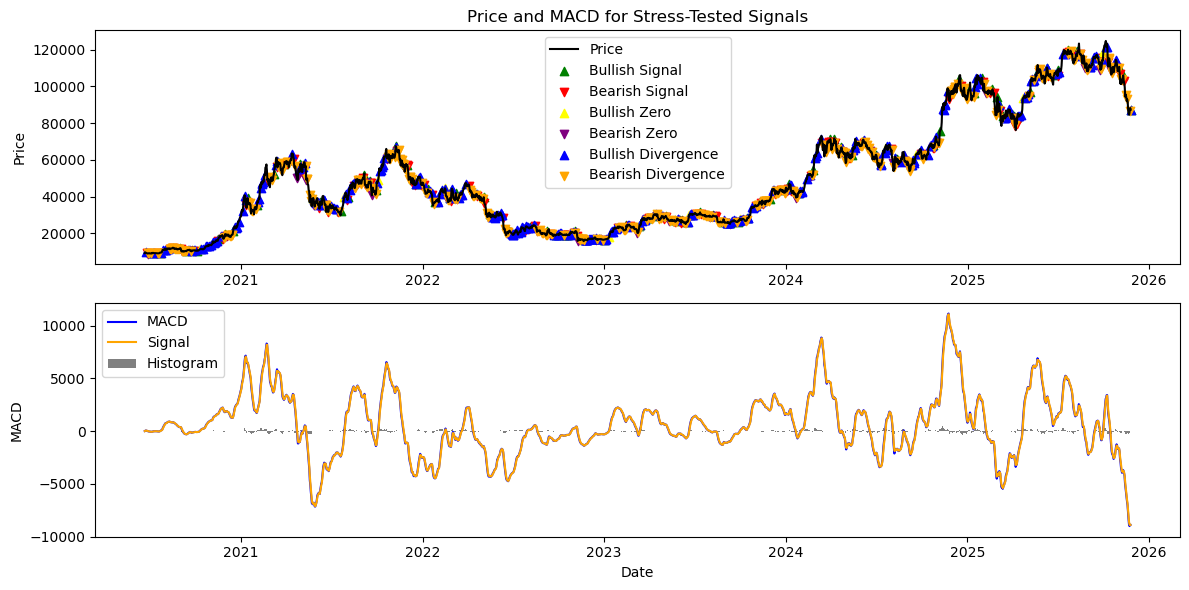

{'Dataframe':                   Prices          MACD        Signal   Histogram  \
 Date                                                               
 2020-06-21  9,303.629883      0.000000      0.000000    0.000000   
 2020-06-22  9,648.717773     32.464714     21.643143   10.821571   
 2020-06-23  9,629.658203     56.914907     45.157653   11.757255   
 2020-06-24  9,313.610352     46.720564     46.199593    0.520970   
 2020-06-25  9,264.813477     33.492573     37.728247   -4.235673   
 ...                  ...           ...           ...         ...   
 2025-11-21 85,090.687500 -8,342.360036 -8,031.763210 -310.596826   
 2025-11-22 84,648.359375 -8,853.195770 -8,579.384917 -273.810853   
 2025-11-23 86,805.007812 -9,005.110971 -8,863.202286 -141.908685   
 2025-11-24 88,270.562500 -8,928.344275 -8,906.630279  -21.713996   
 2025-11-25 87,341.890625 -8,890.901924 -8,896.144709    5.242785   
 
             Price_Change Signal_Crossover Zero_Crossover Divergence  \
 Date           

In [37]:
##Best combination
metr_macd_v4(prices=df_wkd1["BTC-USD"], start_date=best_params['Start'], end_date=best_params['End'],
           short_window=best_params['Short Window'], long_window=best_params['Long Window'], 
             signal_window=best_params['Signal Window'], plot=True)

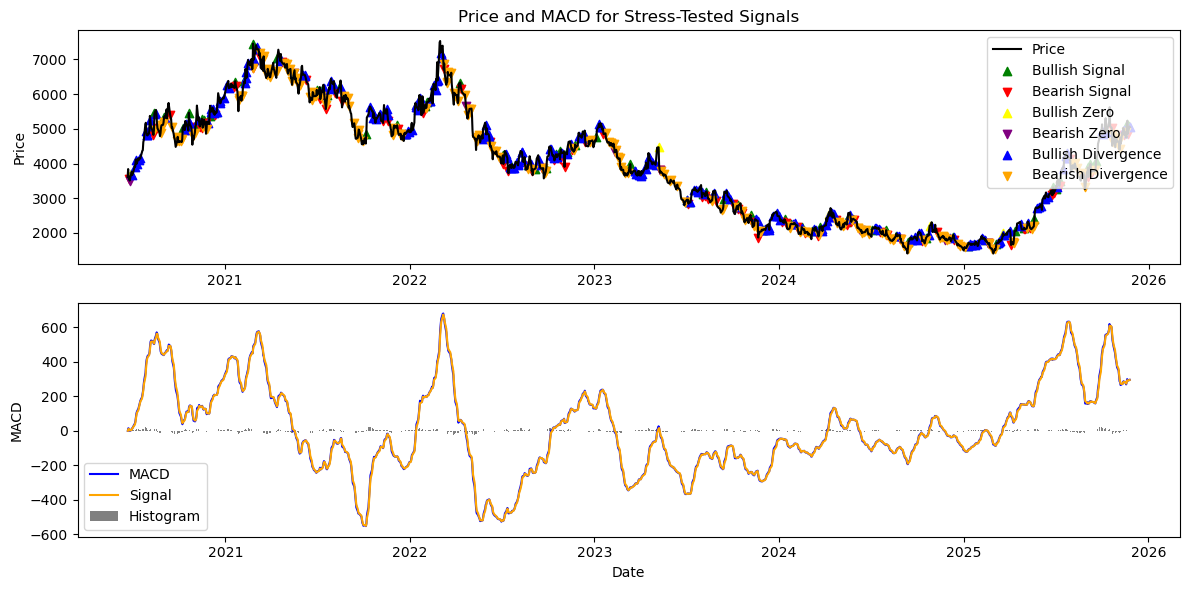

{'Dataframe':                  Prices       MACD     Signal  Histogram  Price_Change  \
 Date                                                                     
 2020-06-22 3,611.918457   0.000000   0.000000   0.000000           NaN   
 2020-06-23 3,841.405029  14.331714   9.554476   4.777238      0.063536   
 2020-06-24 3,591.963623  11.250693  10.685287   0.565406     -0.064935   
 2020-06-25 3,561.032227   6.587665   7.953539  -1.365874     -0.008611   
 2020-06-26 3,510.146240  -0.691401   2.190246  -2.881647     -0.014290   
 ...                 ...        ...        ...        ...           ...   
 2025-11-19 5,138.000000 281.777130 278.552669   3.224461      0.081684   
 2025-11-20 5,232.000000 298.709620 291.990637   6.718984      0.018295   
 2025-11-21 4,860.000000 289.362613 290.238621  -0.876008     -0.071101   
 2025-11-24 5,068.000000 293.269368 292.259119   1.010249      0.042798   
 2025-11-25 5,050.000000 294.648288 293.851898   0.796390     -0.003552   
 
          

In [38]:
##Worst combination
metr_macd_v4(prices=df["SSW.JO"], start_date=less_params['Start'], end_date=less_params['End'],
           short_window=less_params['Short Window'], long_window=less_params['Long Window'], 
             signal_window=less_params['Signal Window'], plot=True)

In [39]:
#Analysis
results_mcd= results_df
#print(results_df)

# Print top results
print(results_mcd.sort_values(by='HScore', ascending=False).dropna())

# Descriptive statistics
print("Descriptive Statistics for 'Score':")
print(results_mcd['HScore'].describe())

# Group-wise average scores by Data
group_summary = results_mcd.groupby(['Data'])['HScore'].mean().reset_index()

print("\n Parameter Combinations by Data:")
print(group_summary.sort_values(by='HScore', ascending=False))

# By Short Window
group_summary = results_mcd.groupby(['Short Window'])['HScore'].mean().reset_index()

print("\nTop Parameter Combinations by Short Window:")
print(group_summary.sort_values(by='HScore', ascending=False))

# By Long Window
group_summary = results_mcd.groupby(['Long Window'])['HScore'].mean().reset_index()

print("\nTop Parameter Combinations by Long Window:")
print(group_summary.sort_values(by='HScore', ascending=False))

# By Signal Window
group_summary = results_mcd.groupby(['Signal Window'])['HScore'].mean().reset_index()

print("\nTop Parameter Combinations by Signal Window:")
print(group_summary.sort_values(by='HScore', ascending=False))

          Data      Start        End  Short Window  Long Window  \
1081   BTC-USD 2020-06-21 2025-11-25            13           40   
1082   BTC-USD 2020-06-21 2025-11-25            13           40   
1080   BTC-USD 2020-06-21 2025-11-25            13           40   
1085   BTC-USD 2020-06-21 2025-11-25            13           50   
1084   BTC-USD 2020-06-21 2025-11-25            13           50   
...        ...        ...        ...           ...          ...   
1073  USDZAR=X 2025-10-25 2025-11-25            20           40   
1078  USDZAR=X 2025-10-25 2025-11-25            20           60   
1079  USDZAR=X 2025-10-25 2025-11-25            20           60   
1071  USDZAR=X 2025-10-25 2025-11-25            20           40   
1072  USDZAR=X 2025-10-25 2025-11-25            20           40   

      Signal Window             Highest Strategy    HScore  \
1081             10  bps_change Signal_Crossover 23.180090   
1082             14  bps_change Signal_Crossover 23.180090   
1080     

## Conclusion

Here

# Master Portfolio

This segment compares all technical strategies and combines all their strong aspects to create a combination of technicals that "maximize" trader profits.

In [40]:
### YTD underlying change (%)

df_ret = df.loc[df.index[-1] - pd.DateOffset(years=0, months=10, days=25):, :].pct_change()
#print(f"Simple Return (%): ", df_ret.sum(axis=0)*100)
print(f"Geometric Return (%): ", (df_ret.add(1).prod() -1)*100)

df_etf_ret = df_etf.loc[df_etf.index[-1] - pd.DateOffset(years=0, months=10, days=24):, :].pct_change()
#print(f"Simple Return (%): ", df_etf_ret.sum(axis=0)*100)
print(f"Geometric Return (%): ", (df_etf_ret.add(1).prod() -1)*100)

df_gld_ret = df_gld.loc[df_gld.index[-1] - pd.DateOffset(years=0, months=10, days=24):, :].pct_change()
#print(f"Simple Return (%): ", df_gld_ret.sum(axis=0)*100)
print(f"Geometric Return (%): ", (df_gld_ret.add(1).prod() -1)*100)

df_wkd_ret = df_wkd.loc[df_wkd.index[-1] - pd.DateOffset(years=0, months=10, days=24):, :].pct_change()
#print(f"Simple Return (%): ", df_wkd_ret.sum(axis=0)*100)
print(f"Geometric Return (%): ", (df_wkd_ret.add(1).prod() -1)*100)

df_wkd1_ret = df_wkd1.loc[df_wkd1.index[-1] - pd.DateOffset(years=0, months=10, days=24):, :].pct_change()
#print(f"Simple Return (%): ", df_wkd1_ret.sum(axis=0)*100)
print(f"Geometric Return (%): ", (df_wkd1_ret.add(1).prod() -1)*100)

Geometric Return (%):  Ticker
PPE.JO    94.444444
SSW.JO   237.116155
dtype: float64
Geometric Return (%):  Ticker
EZA    58.487918
SPY    16.470776
^TYX   -2.917880
dtype: float64
Geometric Return (%):  Ticker
GC=F   55.632891
dtype: float64
Geometric Return (%):  Ticker
USDZAR=X   -8.124166
dtype: float64
Geometric Return (%):  Ticker
BTC-USD   -7.496172
dtype: float64


In [41]:
## Top Strategies

# MACD
print("MACD \n")
bst_mcd = results_mcd.sort_values(by='HScore', ascending=False).dropna().iloc[0]
print(bst_mcd)

# Bollinger Bands
print("Bollinger Bands \n")
bst_b = results_bb.sort_values(by='Score', ascending=False).dropna()
bst_bb = bst_b[bst_b['Data'] == 'BTC-USD'].iloc[0]
print(bst_bb)

# MA Cross
print("MA Cross \n")
bst_max = results_max.sort_values(by='Total Return (%)', ascending=False).dropna().iloc[0]
print(bst_max)

# RSI
print("RSI \n")
bst_rsi = results_rsi.sort_values(by='Total Return (%)', ascending=False).dropna().iloc[0]
print(bst_rsi)

MACD 

Data                                    BTC-USD
Start                       2020-06-21 00:00:00
End                         2025-11-25 00:00:00
Short Window                                 13
Long Window                                  40
Signal Window                                10
Highest Strategy    bps_change Signal_Crossover
HScore                                23.180090
Lowest Strategy           bps_change Divergence
LScore                                -2.349940
Name: 1081, dtype: object
Bollinger Bands 

Data                          BTC-USD
Start             2025-10-25 00:00:00
End               2025-11-25 00:00:00
Window                             20
Standard Dev                       10
Win/Loss_Ratio               2.000000
Score                        0.000000
Name: 418, dtype: object
MA Cross 

Data                            BTC-USD
Start               2020-06-21 00:00:00
End                 2025-11-25 00:00:00
MA_lwr                                1
MA_upp 

In [42]:
# Create Master portfolio
def trading(data, data1, rsi, bb, macd, macx, plot=True):
    df_rsi = metr_rsi_v3(data, bst_rsi['Start'], bst_rsi['End'], bst_rsi['Period'], bst_rsi['RSI_Benchmark'], plot=False)['Dataframe']
    df_crx = metr_ma_crx_v2(data1, macx['Start'], macx['End'], macx['MA_upp'], macx['MA_lwr'], plot=False)['Dataframe']
    ## BB no position
    df_bb = metr_bb_v2(data, bb['Start'], bb['End'], bb['Window'], bb['Standard Dev'], plot=False)['Dataframe']
    df_mcd = metr_macd_v4(data, macd['Start'], macd['End'], macd['Short Window'], macd['Long Window'], macd['Signal Window'], plot=False)['Dataframe']

    # Select columns of interest
    df_dat = pd.DataFrame({"Price": data})
    df_rs = df_rsi[['Trend', 'RSI']]
    df_cr = df_crx.loc[:, ['Short_MA', 'Long_MA', 'MA Signal']]
    df_b = df_bb.loc[:, ['SMA', 'Upper Band', 'Lower Band']]
    df_mc = df_mcd.loc[:, ['MACD', 'Signal', 'Histogram', 'Signal_Crossover']]
    df_mst = pd.concat([df_dat, df_rs, df_cr, df_b, df_mc], axis=1)  

    # Generate positions
    df_rsi_pst = pd.DataFrame({"RSI Position": df_rsi['Position']}) #RSI
    df_crx_pst = pd.DataFrame({"MAX Position": df_crx['MA Signal']}) #MA Cross
    df_bb_pst = pd.DataFrame({"BB Position": df_bb['Position']}) #BB
    df_mcd_pst = pd.DataFrame({"MACD Position": df_mc['Signal_Crossover'].replace({'Bearish': 'Sell', 'Bullish': 'Buy'}) }) #MACD 
    df_mst_pst = pd.concat([df_dat, df_rsi_pst, df_crx_pst, df_bb_pst, df_mcd_pst], axis=1) 
    
    # Performance Testing
    ##Convert to numerics
    mapping = {'Buy': 1, 'Sell': -1, 'None': 0, 'Hold': 0}
    macd_num = df_mst_pst.replace(mapping)
    macd_num = macd_num.astype(float)
    
    columns = [1, 2, 3, 4]
    subsets = []
    for i in range(1, 5):
        comb = combinations(columns, i)
        subsets.extend(comb) # All combinations

    for n in range(15):
        results = []
        # Determine overall Position
        avg = macd_num.iloc[ :, list(subsets[n])].mean(axis=1)
        df_mst_pst.columns[list(subsets[n])]
        df_mst_pst['Temp'] = np.select([ avg > 0, avg < 0], ['Bullish', 'Bearish'], default='None')
        df_mst_pst['Temp'] = df_mst_pst['Temp'].replace('None', pd.NA).ffill()
        signal = df_mst_pst['Temp'].replace(pd.NA, 'None')
        #Drop
        df_mst_pst = df_mst_pst.drop('Temp', axis=1)

        # Implement Short-Selling
        bps_chng = np.where(signal == 'Bullish', df_mst_pst['Price'].pct_change(), #Profit = (next - current)/current
                            np.where(signal == 'Bearish', -df_mst_pst['Price'].pct_change(), 0)) # Short profit = (current - next)/next
        col_nam = df_mst_pst.columns[list(subsets[n])]
        df_mst_pst[f"bps_change {'_'.join(col_nam)}"] = bps_chng

    # Performance Summary
    bps = df_mst_pst.iloc[:, 5:].sum()
    high_bps_nam = bps.idxmax()
    high_bps = bps.max()
    low_bps_nam = bps.idxmin()
    low_bps = bps.min()
    
    # Visualization 
    if plot:
        fig, axes = plt.subplots(3, 1, figsize=(14, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})

        # Price Plot
        axes[0].plot(df_mst.index, df_mst['Price'], label='Price', color='black')

        # RSI Plot
        sell_points = df_mst[df_mst.loc[:, 'RSI'] > bst_rsi['RSI_Benchmark'][0]].index
        buy_points = df_mst[df_mst.loc[:, 'RSI'] < bst_rsi['RSI_Benchmark'][1]].index
        axes[0].scatter(buy_points, df_mst.loc[buy_points, 'Price'], color='green', marker='^', label='RSI Buy Signal')
        axes[0].scatter(sell_points, df_mst.loc[sell_points, 'Price'], color='red', marker='v', label='RSI Sell Signal')
        axes[0].set_title('Price and Signals')
        
        axes[1].plot(df_mst.index, df_mst['RSI'], label='RSI', color='blue')
        axes[1].axhline(bst_rsi['RSI_Benchmark'][0], color='red', linestyle='--', label=f'Overbought {bst_rsi['RSI_Benchmark'][0]}')
        axes[1].axhline(bst_rsi['RSI_Benchmark'][1], color='green', linestyle='--', label=f'Oversold {bst_rsi['RSI_Benchmark'][1]}')
        axes[1].set_title('RSI Levels')
        axes[1].legend()
                
        # MA Cross
        axes[0].plot(df_mst['Short_MA'], label=f'Short MA - {macx['MA_lwr']}', linestyle='--', alpha=0.6)
        axes[0].plot(df_mst['Long_MA'], label=f'Long MA - {macx['MA_upp']}', linestyle='--', alpha=0.6)
        gcrss_pnt = df_mst[ (df_mst['MA Signal']!=df_mst['MA Signal'].shift()) & (df_mst['Short_MA']>df_mst['Long_MA']) ].index
        dcrss_pnt = df_mst[ (df_mst['MA Signal']!=df_mst['MA Signal'].shift()) & (df_mst['Short_MA']<df_mst['Long_MA']) ].index
        axes[0].scatter(gcrss_pnt, df_mst.loc[gcrss_pnt, 'Price'], facecolors='none', edgecolors='green', marker='o', label='Golden Cross')
        axes[0].scatter(dcrss_pnt, df_mst.loc[dcrss_pnt, 'Price'], facecolors='none', edgecolors='red', marker='o', label='Death Cross')
        
        # Bollinger Bands 
        axes[0].plot(df_mst.index, df_mst['SMA'], label='SMA', color='orange')
        axes[0].plot(df_mst.index, df_mst['Upper Band'], label='Upper Band', color='blue')
        axes[0].plot(df_mst.index, df_mst['Lower Band'], label='Lower Band', color='purple')
        
        buy_points = df_mst[(df_mst['Price'] <= df_mst['Lower Band'])].index
        sell_points = df_mst[(df_mst['Price'] >= df_mst['Upper Band'])].index

        axes[0].scatter(buy_points, df_mst.loc[buy_points], color='green', marker='^', label='BB Buy Signal')
        axes[0].scatter(sell_points, df_mst.loc[sell_points], color='red', marker='v', label='BB Sell Signal')

        # MACD
        axes[0].scatter(df_mst.index[(df_mst['Signal_Crossover']!=df_mst['Signal_Crossover'].shift()) & (df_mst['Signal_Crossover'] == 'Bullish')],
                    df_mst['Price'][(df_mst['Signal_Crossover']!=df_mst['Signal_Crossover'].shift()) & (df_mst['Signal_Crossover'] == 'Bullish')], 
                        marker='^', color='blue', label='Bullish MACD Signal')
        axes[0].scatter(df_mst.index[(df_mst['Signal_Crossover']!=df_mst['Signal_Crossover'].shift()) & (df_mst['Signal_Crossover'] == 'Bearish')],
                    df_mst['Price'][(df_mst['Signal_Crossover']!=df_mst['Signal_Crossover'].shift()) & (df_mst['Signal_Crossover'] == 'Bearish')], 
                        marker='v', color='orange', label='Bearish MACD Signal')
        axes[0].legend(ncol=2, fontsize=10)
        
        axes[2].plot(df_mst.index, df_mst['MACD'], label='MACD', color='blue')
        axes[2].plot(df_mst.index, df_mst['Signal'], label='Signal', color='orange')
        axes[2].bar(df_mst.index, df_mst['Histogram'], color='gray', label='Histogram')
        axes[2].legend()
        axes[2].set_xlabel('Date')
        axes[2].set_title('MACD')
        plt.tight_layout()
        plt.show()
    return {'Dataframe': df_mst, 'Technical Positions':df_mst_pst, 'Strategy Returns (%)': bps, 'Highest Strategy':high_bps_nam,
            'Highest Returns': high_bps, 'Lowest Strategy':low_bps_nam, 'Lowest Returns': low_bps}

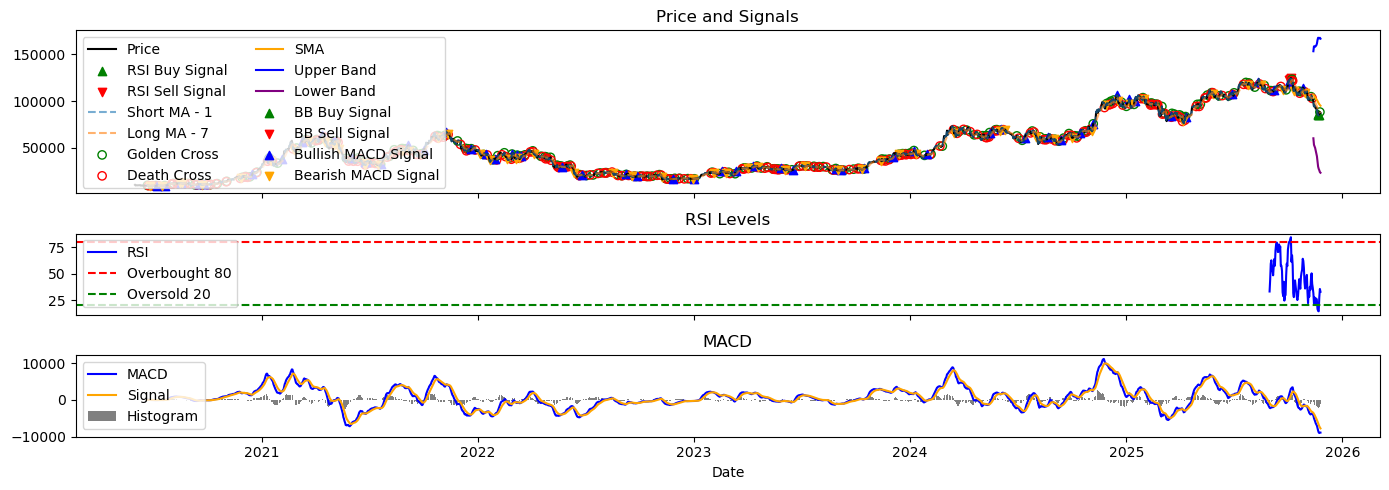

{'Dataframe':                    Price      Trend       RSI      Short_MA       Long_MA  \
 Date                                                                        
 2020-06-01 10,167.268555        NaN       NaN           NaN           NaN   
 2020-06-02  9,529.803711        NaN       NaN           NaN           NaN   
 2020-06-03  9,656.717773        NaN       NaN           NaN           NaN   
 2020-06-04  9,800.636719        NaN       NaN           NaN           NaN   
 2020-06-05  9,665.533203        NaN       NaN           NaN           NaN   
 ...                  ...        ...       ...           ...           ...   
 2025-11-21 85,090.687500  Downtrend 14.858160 85,090.687500 91,136.793527   
 2025-11-22 84,648.359375  Downtrend 14.378207 84,648.359375 89,579.537946   
 2025-11-23 86,805.007812    Uptrend 27.668715 86,805.007812 88,526.385045   
 2025-11-24 88,270.562500    Uptrend 35.594620 88,270.562500 87,980.197545   
 2025-11-25 87,341.890625  Downtrend 32.927239 87,3

In [43]:
trading(df_wkd1["BTC-USD"], df_wkd1[["BTC-USD"]], bst_rsi, bst_bb, bst_mcd, bst_max, plot=True)